# Setup

In [2]:
import os
import sys

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
import xesmf as xe
import xcdat as xc
import xsearch as xs
import xskillscore as xscore

from glob import glob 
from global_land_mask import globe
from scipy.stats import linregress
from scipy.linalg import lstsq
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Sequence, cast

# Ignore xarray warnings (bad practice)
import warnings
warnings.simplefilter("ignore") 

# Define Constants
prctl_bins = np.arange(0,105,5) # bottom edge of percentile bins
prctl_binmids = (prctl_bins[:-1]+prctl_bins[1:])/2 # center of percentile bins

# Plotting Utils

In [3]:
plt.rcParams.update({
    'font.size': 16,        # Global font size
    'axes.labelsize': 16,   # Font size for axis labels
    'axes.titlesize': 16,   # Font size for subplot titles
    'legend.fontsize': 12,  # Font size for legend
    'xtick.labelsize': 12,  # Font size for x-axis tick labels
    'ytick.labelsize': 12   # Font size for y-axis tick labels
})

## SST plotting

In [4]:
def create_percentile_figures(ds: xr.Dataset, model: str) -> None:
    time = ds.time
    percentiles = ds.bins

    fig, axes = plt.subplots(3, 1, figsize=(30, 20), sharey=True)
    fig.subplots_adjust(hspace=0.4)

    # Plot Binaverages
    im = axes[0].pcolor(time,percentiles, ds.binavg.T, vmin=16,vmax=32) 
    axes[0].set_title("Average SST in each percentile bin", loc="left")
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label('K')

    # Plot Binanomalies
    im = axes[1].pcolor(time,percentiles, ds.binanom.T, vmin=-1,vmax=1, cmap='RdBu_r')
    twin_ax1 = axes[1].twinx()
    twin_ax1.plot(time, ds.mean_anom, color='black', label="average", linewidth=4)
    cbar = fig.colorbar(im, ax=axes[1])
    axes[1].set_title("SST Anomaly from bin average over climatology", loc="left")
    twin_ax1.legend()
    cbar.set_label('K')

    # Plot Binanomalies Bar
    im = axes[2].pcolor(time,percentiles, ds.binanom_bar.T, vmin=-1,vmax=1, cmap='RdBu_r')
    axes[2].set_title("SST Anomalies relative to tropical average", loc="left")
    twin_ax2 = axes[2].twinx()
    twin_ax2.plot(time, (ds.sharp - ds.flat), color='black', label="SST# - SSTb", linewidth=4)
    twin_ax2.hlines(np.nanmean(ds.sharp - ds.flat), xmin=time[0], xmax=time[-1], color="gray", linestyle="--", linewidth=4) 
    twin_ax2.legend()
    cbar = fig.colorbar(im, ax=axes[2])
    cbar.set_label('K')

    for ax in axes:
        ax.set_ylim(0, 100)
        ax.set_ylabel('SST percentile')
        ax.set_xlabel('Time')

    axes[0].set_title(model, fontsize=30, fontweight="bold", loc="right")

    # Save figure to folder figures as pdf
    plt.savefig(f"figures/{model}_percentiles.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_percentiles.png", bbox_inches='tight')

# create_percentile_figures(ds, model="CESM2_test")

## SWCRE plotting

In [5]:
def create_swcre_percentile_figures(ds: xr.Dataset, model: str) -> None:
    time = ds.time
    percentiles = ds.bins

    fig, axes = plt.subplots(3, 1, figsize=(30, 20), sharey=True)
    fig.subplots_adjust(hspace=0.4)

    # Plot Binaverages
    im = axes[0].pcolor(time,percentiles, ds.binavg.T) #, vmin=-120, vmax=0)
    axes[0].set_title("Average SWCRE in each percentile bin", loc="left")
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label(r'$Wm^{-2}$')

    # Plot Binanomalies
    im = axes[1].pcolor(time,percentiles, ds.binanom.T, cmap='RdBu_r', vmax=10, vmin=-10)
    twin_ax1 = axes[1].twinx()
    twin_ax1.plot(time, ds.mean_anom, color='black', label="average", linewidth=4)
    cbar = fig.colorbar(im, ax=axes[1])
    axes[1].set_title("SWCRE Anomaly from bin average over climatology", loc="left")
    twin_ax1.legend()
    cbar.set_label(r'$Wm^{-2}$')

    # Plot Binanomalies Bar
    im = axes[2].pcolor(time,percentiles, ds.binanom_bar.T, cmap='RdBu_r', vmax=10, vmin=-10)
    axes[2].set_title("SWCRE Anomalies relative to tropical average", loc="left")
    twin_ax2 = axes[2].twinx()
    twin_ax2.plot(time, (ds.sharp - ds.flat), color='black', label="SWCRE# - SWCREb", linewidth=4)
    twin_ax2.hlines(np.nanmean(-(ds.sharp - ds.flat)), xmin=time[0], xmax=time[-1], color="gray", linestyle="--", linewidth=4) 
    twin_ax2.legend()
    cbar = fig.colorbar(im, ax=axes[2])
    cbar.set_label(r'$Wm^{-2}$')

    for ax in axes:
        ax.set_ylim(0, 100)
        ax.set_ylabel('SWCRE sorted on SST percentile')
        ax.set_xlabel('Time')

    axes[0].set_title(model, fontsize=30, fontweight="bold", loc="right")

    # Save figure to folder figures as pdf
    plt.savefig(f"figures/{model}_SWCRE_percentiles.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_SWCRE_percentiles.png", bbox_inches='tight')

# create_percentile_figures(ds, model="CESM2_test")

## SST Trend plotting

In [6]:
def sanity_rolling_trend(window: int, sharp: xr.DataArray, flat: xr.DataArray, trend: xr.DataArray, raw: xr.DataArray, model: str) -> None:
    # Create matplotlib 2 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 20))
    ax1_twin = ax1.twinx()
    ntime = sharp.shape[0]
    time = np.arange(ntime)

    # Add grid lines to all subplots
    ax1.grid(); ax2.grid(); ax3.grid()

    # Plot time vs trend on ax1
    ax1.plot(time, raw, color='black', label=r"SST$d$", linewidth=4)

    # Plot sharp on ax1_twin
    ax1_twin.plot(time, flat, color='purple', label=r"SST$b$", linewidth=4)
    ax1_twin.plot(time, sharp, color='maroon', label=r"SST#", linewidth=4)
    ax1.set_ylabel(r"SST$d$ (K)"); ax1_twin.set_ylabel(r"SST# and SST$b$ (K)")
    ax1.set_title(r"SST$d$ (SST# - SST$b$)", loc="left", fontweight="bold")
    # Set x tick labels starting in 1850 every 5 years 
    ax1.set_xticklabels(np.arange(1850, 1850+int(ntime/12), 10))
    ax1.set_xticks(time[::12*10])
    # Add a black horizontal line at 0 
    ax1.hlines(0, xmin=time[0], xmax=time[-1], color="black", linestyle="--", linewidth=4)
    # Retrieve the handles and labels from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax1_twin.get_legend_handles_labels()
    # Concatenate the handles and labels from both axes
    handles = handles1 + handles2
    labels = labels1 + labels2
    # Create the legend using the concatenated handles and labels
    ax1.legend(handles, labels)
    
    # Set ylim of twin_ax1 to be 20% larger than the range of the data
    ax1_twin.set_ylim(np.nanmin(raw)*1.2, np.nanmax(raw)*1.2)
    ax1.set_ylim(np.nanmin(raw)*1.2, np.nanmax(raw)*1.2)

    # Plot ntime vs trend on ax2
    # trend_time = np.arange(int(window/2), ntime - int(window/2))
    ntrend = trend.shape[0]
    ax2.plot(np.arange(ntrend), trend, color='black', label="trend", linewidth=4)
    yrs_window = window/(12*2) # half the years of the length of the window
    xticks = np.arange(0, ntrend, 10)
    xticklabels = np.arange(1850 + yrs_window, 1850 + yrs_window + ntrend, 10) 
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticklabels)
    ax2.set_xlim(0, ntrend)

    ax2.set_title("SST Trend (K/30yr)", loc="left", fontweight="bold")
    ax2.set_ylabel("SST Trend (K/30yr)"); ax2.set_xlabel("Time")
    ax2.hlines(0, xmin=0, xmax=ntrend, color="black", linestyle="--", linewidth=4)

    hist = sns.histplot(trend, ax=ax3, kde=True, stat="density", linewidth=0)
    ax3.set_title(r"SST$d$ Trend (K/30yr)", loc="left", fontweight="bold")
    ax3.set_title(f"mean: {np.mean(trend):.2f}, variance: {np.var(trend):.2f}", loc="right", fontweight="bold")
    # Add a vertical line at the mean of the trend and the variance and have the ymin and ymax be the max of the histogram
    ax3.vlines(np.mean(trend), ymin=0, ymax=np.max(hist.get_lines()[0].get_data()[1]), color="black", linestyle="--", linewidth=4)
    fig.suptitle(model, fontsize=30, fontweight="bold", y=0.95)

    # Save figure to folder figures as pdf
    plt.savefig(f"figures/{model}_trend.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_trend.png", bbox_inches='tight')


## SWCF plotting

In [7]:
def plot_swcf(swcf: xr.DataArray, model: str = ""):
    """Plot the SWCF

    Args:
        swcf (xr.DataArray): SWCF
    """
    fig, ax = plt.subplots(1,1, figsize=(5,3))

    ax.plot(swcf.bins, swcf.values, label=model, linewidth=4)
    ax.legend()
    ax.set_title("SWCF", loc="left", fontweight="bold")
    ax.set_xlabel("Percentile")
    ax.set_ylabel(r"SWCF [$Wm^{-2}K^{-1}$]")
    ax.set_xlim(0, 100)
    ax.grid()
    ax.axhline(y=0, color="black", linestyle="--")
    # Save figure
    plt.savefig(f"figures/{model}_SWCF.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_SWCF.png", bbox_inches='tight')

# plot_swcf(swcf, model="CESM2_test")

# SST Sharp Utils

In [8]:
"""
Library to compute weighted quantiles, including the weighted median, of
numpy arrays.

https://github.com/nudomarinero/wquantiles
"""
def quantile_1D(data, weights, quantile):
    """
    Compute the weighted quantile of a 1D numpy array.

    Parameters
    ----------
    data : ndarray
        Input array (one dimension).
    weights : ndarray
        Array with the weights of the same size of `data`.
    quantile : float
        Quantile to compute. It must have a value between 0 and 1.

    Returns
    -------
    quantile_1D : float
        The output value.
    """
    # Check the data
    if not isinstance(data, np.matrix):
        data = np.asarray(data)
    if not isinstance(weights, np.matrix):
        weights = np.asarray(weights)
    nd = data.ndim
    if nd != 1:
        raise TypeError("data must be a one dimensional array")
    ndw = weights.ndim
    if ndw != 1:
        raise TypeError("weights must be a one dimensional array")
    if data.shape != weights.shape:
        raise TypeError("the length of data and weights must be the same")
    if ((quantile > 1.) or (quantile < 0.)):
        raise ValueError("quantile must have a value between 0. and 1.")
    # Sort the data
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    # Compute the auxiliary arrays
    Sn = np.cumsum(sorted_weights)
    # TODO: Check that the weights do not sum zero
    #assert Sn != 0, "The sum of the weights must not be zero"
    Pn = (Sn-0.5*sorted_weights)/Sn[-1]
    # Get the value of the weighted median
    return np.interp(quantile, Pn, sorted_data)


# def get_percentiles(data,wts,bins):
#     # wrapper for previous functions
#     quantiles = bins/100
#     return np.quantile(data, quantiles)

def get_percentiles(data,wts,bins):
    # wrapper for previous functions
    quantiles = bins/100
    newbins=[]
    # if len(np.where(np.isnan(data))[0]) > 0:
        # raise Exception

    # return np.quantile(data, quantiles)
    for q in quantiles:
        newbins.append(quantile_1D(data, wts, q))
    return newbins

# Testing
# bins = get_percentiles(list(np.random.rand((100))) + list([np.nan, np.nan, np.nan]), np.ones(103), bins=np.arange(0, 110, 10))
# bins = get_percentiles(np.random.rand((100)), np.ones(100), bins=np.arange(0, 110, 10))
# bins

## SST Sharp Sorting

In [9]:
def do_SSTsharp_sorting(da: xr.DataArray, prctl_bins: np.ndarray, prctl_binmids: np.ndarray, weights: np.ndarray) -> xr.Dataset:
    """The goal of this function is to calculate SSTsharp as defined in Fueglistaler (2019)

        Observational evidence for two modes of coupling between sea surface temperatures, 
        tropospheric temperature profile, and shortwave cloud radiative effect in the tropics. 
        Geophysical Research Letters, 46, 9890–9898. https://doi.org/10.1029/2019GL083990

    Args:
        ds (xr.DataArray): _description_
        nbins (int, optional): _description_. Defaults to 20.

    Returns:
        ds (xr.Dataset): containing the following xr.DataArrays:
            bingavg (xr.DataArray)[time, percentile]: average temperature in each percentile bin with quantile defined at that time step
            binanom (xr.DataArray)[time, percentile]: average temperature in each percentile bin minus the monthly climatology
            sortIdxs (xr.DataArray)[time, lon]: Indexes of the sorted data that can be used to sort other dataX (e.g. swcre, rsut, rsutcs) using dataY (e.g. SST)
            binanom_bar (xr.DataArray)[time, percentile]: binanoms minus the tropical average SST at that time step
            mean_anom (xr.DataArray)[time, percentile]: tropical average SST anomaly at that time step
            sharp (xr.DataArray)[time]: The average of binanom_bar over the warmest 30% at each time step
            flat (xr.DataArray)[time]:  The average of binanom_bar over the coldest 30% at each time step 

    """
    ntime, nlat, nlon = da.shape
    nbins = len(prctl_bins)

    binavg = np.zeros((ntime,nbins))
    binwts = np.zeros((ntime,nbins))
    sortIdxs = np.zeros((ntime,nlon*nlat))
    not_nans = np.zeros((ntime,nlon*nlat))
    not_nans.fill(np.nan)
    sortIdxs.fill(np.nan)

    for i in range(ntime):
        # print(da.isel(time=i).lat.values, da.isel(time=i).lon.values)
        da_slice = da.isel(time=i).to_numpy().flatten()
        wts_slice = weights[i,:,:].to_numpy().flatten()
        # print("da_slice shape: ", da_slice.shape)
        # print("wts_slice shape: ", wts_slice.shape)

        # Remove nans
        v = np.where(~np.isnan(da_slice))[0] 
        not_nans[i,:len(v)] = v
        wts_slice = wts_slice[v]
        da_slice = da_slice[v]
        # print("da_slice shape after nans removed: ", da_slice.shape)
        # print("wts_slice shape after nans removed: ", wts_slice.shape)

        # Calculate percentiles (these are the values separating the quantiles)
        bins = get_percentiles(da_slice, wts_slice, prctl_bins)
        inds = np.digitize(da_slice, bins)
        sortIdxs[i,:len(da_slice)] = inds
        # print("sortIdxs : ", inds.shape)
        # print(np.max(inds), np.min(inds), inds[:20])
        # print(wts_slice[:20])

        for j, b in enumerate(np.arange(nbins)): # note that bin 0 only has a single (max) value
            numer = np.nansum(da_slice[np.where(inds==b)]*wts_slice[np.where(inds==b)])
            denom = np.nansum(wts_slice[np.where(inds==b)])
            binavg[i,j] = numer/denom
            binwts[i,j] = denom

        # print(binavg[i,:])
        # print(binwts[i,:])

    # Deseasonalize the data -- remove climatology computed over entire timeseries:
    binanom = np.zeros((ntime,nbins))
    for m in range(12):
        binanom[m::12,:] = binavg[m::12,:] - np.nanmean(binavg[m::12, :], 0)
    
    # Time slice SST Tropical mean
    TMean = np.nansum(binanom*binwts,axis=1) / np.nansum(binwts,axis=1)
    # Calculate binanom_bar
    binanom_bar = binanom - TMean[:, None]
    
    # Calculate SSTsharp
    sharpThreshold = np.where(prctl_bins >= 70)[0]
    sharp = np.nansum(binanom_bar[:,sharpThreshold]*binwts[:,sharpThreshold], axis=1) / np.nansum(binwts[:, sharpThreshold], axis=1)
    # Calculate SSTflat
    flatThreshold = np.where(prctl_bins <= 30)[0]
    flat = np.nansum(binanom_bar[:,flatThreshold]*binwts[:,flatThreshold], axis=1) / np.nansum(binwts[:, flatThreshold], axis=1)  

    # Create Dataset => remove first element that is nan for all bins
    ds = xr.Dataset({
        'binavg':(('time','bins'), binavg[:, 1:]),
        'binanom': (('time','bins'), binanom[:, 1:]), 
        'sortIdxs': (('time','idx'), sortIdxs), 
        'not_nans': (('time','idx'), not_nans), 
        'binanom_bar': (('time','bins'), binanom_bar[:, 1:]),
        'binwts':(('time','bins'), binwts[:, 1:]),
        'mean_anom':(('time'), TMean),
        'sharp':(('time'), sharp),
        'flat':(('time'), flat)
    },
        coords={
            'time': da.time, 
            'bins': prctl_binmids.data,
            'idx': np.arange(nlat*nlon),
        }
    ) 
    
    return ds


## SWCRE Sorting

In [10]:
def apply_SSTsharp_to_SWCRE(da: xr.DataArray, prctl_bins: np.ndarray, ds_sharp: xr.Dataset, weights: np.ndarray, model: str) -> xr.Dataset:
    """Apply SSTsharp sorting to SWCRE

    Args:
        da (xr.DataArray): swcre raw monthly data
        prctl_bins (np.ndarray): percentiles to use for sorting from ds_sharp
        ds_sharp (xr.Dataset): SST sharp package
        model (str): name of model

    Returns:
        ds (xr.Dataset): containing the following xr.DataArrays:
            bingavg (xr.DataArray)[time, percentile]: average SWCRE in each percentile bin with quantile defined at that time step
            binanom (xr.DataArray)[time, percentile]: average SWCRE in each percentile bin minus the monthly climatology
            binanom_bar (xr.DataArray)[time, percentile]: binanoms minus the tropical average SWCRE at that time step
            mean_anom (xr.DataArray)[time, percentile]: tropical average SST anomaly at that time step
            sharp (xr.DataArray)[time]: The average of binanom_bar over the warmest 30% at each time step
            flat (xr.DataArray)[time]:  The average of binanom_bar over the coldest 30% at each time step 
    """
    ntime, _, _ = da.shape
    nbins = len(prctl_bins)
    
    binavg = np.zeros((ntime,nbins))
    binwts = np.zeros((ntime,nbins))

    for i in range(ntime):
        # Get current time slice
        # print(da.isel(time=i).lat.values, da.isel(time=i).lon.values)
        da_slice = da.isel(time=i).to_numpy().flatten()
        wts_slice = weights[i, :, :].to_numpy().flatten()
        # print("da_slice shape: ", da_slice.shape)
        # print("wts_slice shape: ", wts_slice.shape)
       
        # Remove values where corresponding SST data is nan
        sst_non_nans = ds_sharp["not_nans"].isel(time=i).values
        sst_non_nans = np.array(sst_non_nans[~np.isnan(sst_non_nans)], dtype=int)
        da_slice = da_slice[sst_non_nans]
        wts_slice = wts_slice[sst_non_nans]
        # print("da_slice shape after nans removed: ", da_slice.shape)
        # print("wts_slice shape after nans removed: ", wts_slice.shape)

        # Remove filler nans from sorted inds
        inds = ds_sharp["sortIdxs"].isel(time=i).values
        inds = inds[np.where(~np.isnan(inds))] 
        # print("sortIdxs shape: ", inds.shape)

        # Remove nans from SWCRE 
        nanMask = np.where(~np.isnan(da_slice))[0]
        wts_slice = wts_slice[nanMask]
        da_slice = da_slice[nanMask]
        inds = np.array(inds[nanMask], dtype=int)
        # print("da_slice shape after nans removed: ", da_slice.shape)
        # print("wts_slice shape after nans removed: ", wts_slice.shape)
        # print(np.max(inds), np.min(inds), inds[:20])
        # print(wts_slice[:20])

        # Calculate percentiles (these are the values separating the quantiles)
        # bins = get_percentiles(da_slice, wts_slice, prctl_bins)
        # inds = np.digitize(da_slice, bins)

        for j, b in enumerate(np.arange(nbins)): # note that bin 0 only has a single (max) value
            numer = np.nansum(da_slice[np.where(inds==b)]*wts_slice[np.where(inds==b)])
            denom = np.nansum(wts_slice[np.where(inds==b)])
            binavg[i,j] = numer/denom
            binwts[i,j] = denom
        
        # print(binavg[i,:])
        # print(binwts[i,:])

    # Deseasonalize the data -- remove climatology computed over entire timeseries:
    binanom = np.zeros((ntime,nbins))
    for m in range(12):
        binanom[m::12,:] = binavg[m::12,:] - np.nanmean(binavg[m::12, :], 0)
    # binanom[:,:] = binavg[:,:] - np.nanmean(binavg[:, :], 0)
    
    # Time slice SWCRE Tropical mean
    TMean = np.nansum(binanom*binwts,axis=1) / np.nansum(binwts,axis=1)
    # Calculate binanom_bar
    binanom_bar = binanom - TMean[:, None]

    # Calculate SWCREsharp
    sharpThreshold = np.where(prctl_bins >= 70)[0]
    sharp = np.nansum(binanom_bar[:,sharpThreshold]*binwts[:,sharpThreshold], axis=1) / np.nansum(binwts[:, sharpThreshold], axis=1)
    # Calculate SWCREflat
    flatThreshold = np.where(prctl_bins <= 30)[0]
    flat = np.nansum(binanom_bar[:,flatThreshold]*binwts[:,flatThreshold], axis=1) / np.nansum(binwts[:, flatThreshold], axis=1)  

    # Create Dataset => remove first element that is nan for all bins
    ds = xr.Dataset({
        'binavg':(('time','bins'), binavg[:, 1:]),
        'binanom': (('time','bins'), binanom[:, 1:]), 
        'binanom_bar': (('time','bins'), binanom_bar[:, 1:]),
        'binwts':(('time','bins'), binwts[:, 1:]),
        'mean_anom':(('time'), TMean),
        'sharp':(('time'), sharp),
        'flat':(('time'), flat)
    },
        coords={
            'time': da.time, 
            'bins': prctl_binmids,
        }
    ) 
    
    return ds



## Calculate SST Rolling Trend

In [70]:
def calculate_rolling_trend(data: xr.Dataset, model: str = "", window: int = 12*30, step: int = 12) -> xr.Dataset:
    """Calculate the rolling gradient of a dataset

    Args:
        data (xr.Dataset): _description_
        window (int, optional): _description_. Defaults to 120*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """

    # Calculate SSTd = SSTsharp (warm) - SSTflat (cold)
    SSTd = data["sharp"] - data["flat"]
    SSTsharp = data["sharp"] 
    SSTflat = data["flat"]
    ntime = SSTd.shape[0]

    SSTd_trend = np.zeros(int(np.ceil(np.ceil((ntime - window)/12))))
    SSTsharp_trend = np.zeros(int(np.ceil(np.ceil((ntime - window)/12))))
    SSTflat_trend = np.zeros(int(np.ceil(np.ceil((ntime - window)/12))))
    SSTd_trend.fill(np.nan)
    SSTsharp_trend.fill(np.nan)
    SSTflat_trend.fill(np.nan)

    # Calculate rolling trend of SSTd
    time_idx = xr.DataArray(np.arange(window), dims=("time"))
    for j, i in enumerate(range(0, ntime - window, step)):
        slice_SSTd = SSTd.isel(time=slice(i, int(i+window)))
        slice_SSTsharp = SSTsharp.isel(time=slice(i, int(i+window)))
        slice_SSTflat = SSTflat.isel(time=slice(i, int(i+window)))
        SSTd_trend[j] = xscore.linslope(time_idx, slice_SSTd, dim='time', skipna=True).values
        SSTsharp_trend[j] = xscore.linslope(time_idx, slice_SSTsharp, dim='time', skipna=True).values
        SSTflat_trend[j] = xscore.linslope(time_idx, slice_SSTflat, dim='time', skipna=True).values
    
    # Convert SSTd trend and SSTd to xr.DataArray
    SSTd_trend = xr.DataArray(SSTd_trend, dims=("time"), coords={"time": np.arange(SSTd_trend.shape[0])})
    SSTsharp_trend = xr.DataArray(SSTsharp_trend, dims=("time"), coords={"time": np.arange(SSTd_trend.shape[0])})
    SSTflat_trend = xr.DataArray(SSTflat_trend, dims=("time"), coords={"time": np.arange(SSTd_trend.shape[0])})
    # Convert SSTd to xr.DataArray
    SSTd = xr.DataArray(SSTd, dims=("time"), coords={"time": np.arange(SSTd.shape[0])})
    SSTsharp= xr.DataArray(SSTsharp, dims=("time"), coords={"time": np.arange(SSTd.shape[0])})
    SSTflat = xr.DataArray(SSTflat, dims=("time"), coords={"time": np.arange(SSTd.shape[0])})
    # Combine SSTd and SSTd_trend into xr.Dataset
    ds = xr.Dataset({"SSTd": SSTd, "SSTd_trend": SSTd_trend, "SSTsharp": SSTsharp, "SSTsharp_trend": SSTsharp_trend, "SSTflat": SSTflat, "SSTflat_trend": SSTflat_trend})

    # Sanity plot of SSTd and SSTd_trend
    # sanity_rolling_trend(window=window, sharp=data["sharp"], flat=data["flat"], trend=SSTd_trend*window, raw=SSTd, model=model) 

    return ds


## Calculate SWCF

In [91]:
def calculate_swcf_percentiles(SSTsharp: xr.Dataset, SWCREsharp: xr.Dataset) -> xr.Dataset:
    swcre_anoms = SWCREsharp["binanom"]
    sst_anoms = SSTsharp["binanom"]
    sst_anoms["time"] = swcre_anoms.time
    swcf = xscore.linslope(sst_anoms, swcre_anoms, dim='time', skipna=True)
    return swcf

# swcf = calculate_swcf_percentiles(SSTsharp=ds["CESM2"], SWCREsharp=swcre)
# swcf

# Process all models

In [74]:
def get_sharp_data(ds: xr.Dataset, output_grid: xr.Dataset, var: str = "tos") -> Tuple[xr.Dataset, xr.Dataset]:
    # Regrid to be same as CMIP data (2.5deg x 2.5deg)
    ds = ds.regridder.horizontal(var, output_grid, tool='xesmf', method='bilinear')
    ds = xc.swap_lon_axis(ds, to=(-180, 180))

    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.lon,ds.lat)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],1,1))
    # plt.contourf(tos.lon, tos.lat, globe_land_mask_nd[0]) # Sanity check plot
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 

    # Get Area Weights:
    wt = ds.spatial.get_weights(axis=["Y", "X"])
    AW = (wt/wt.sum()) # summing this over lat and lon = 1
    _, area_wts = xr.broadcast(ds.time,AW)
    weights = xr.where(globe_land_mask_nd==True,0,area_wts)    

    # FOCUS ON TROPICS FOR SST SHARP CALCULATIONS
    ds_tropics = ds_no_land.sel(lat=slice(-30,30))
    weights_tropics = weights.sel(lat=slice(-30,30))

    ds_tropics.load()

    print(ds_tropics.shape)
    
    return ds_tropics, weights_tropics

def get_swcre_sharp_data(swcre: xr.Dataset, output_grid: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]: 
    pass

# Load Observations
CERES = "CERES_EBAF-TOA_Ed4.1_Subset_200003-202201.nc"
COBE2 = "COBE2.sst.mon.mean.nc"
HADSST4 = "HadSST.4.0.1.0_median.nc"
NOAA_ERSST_V5 = "NOAA_ERSST_V5_sst.mnmean.nc" 
ERA5_SST = "ts_mon_ERA5_197901-202212.nc" 

# Create output grid
lat = np.arange(-88.75, 90, 2.5)
lon = np.arange(1.25, 360, 2.5)
output_grid = xc.create_grid(lat, lon)

# Radiation Data
ceres = xr.open_dataset(f"data/obs/{CERES}")

rsut = ceres.toa_sw_all_mon
rsutcs = ceres.toa_sw_clr_c_mon
swcre = rsutcs - rsut
swcre = swcre.rename("swcre").to_dataset()
swcre_tropics, _ = get_sharp_data(ds=swcre, output_grid=output_grid, var="swcre")

# SST Data
cobe2 = xr.open_dataset(f"data/obs/{COBE2}").sst.rename("tos").sel(time=ceres.time, method="nearest").to_dataset()
hadsst4 = xr.open_dataset(f"data/obs/{HADSST4}").tos.rename("tos").sel(time=ceres.time, method="nearest").to_dataset()
noaaV5 = xr.open_dataset(f"data/obs/{NOAA_ERSST_V5}").sst.rename("tos").sel(time=ceres.time, method="nearest").to_dataset()
era5sst = xr.open_dataset(f"data/obs/{ERA5_SST}").skt.rename("tos").sel(time=ceres.time, method="nearest").to_dataset() - 273.15

cobe2_tropics, weights_tropics = get_sharp_data(ds=cobe2, output_grid=output_grid)
hadsst4_tropics, _ = get_sharp_data(ds=hadsst4, output_grid=output_grid)
noaaV5_tropics, _ = get_sharp_data(ds=noaaV5, output_grid=output_grid)
era5sst_tropics, _ = get_sharp_data(ds=era5sst, output_grid=output_grid)


(263, 24, 144)
(263, 24, 144)
(263, 24, 144)
(263, 24, 144)
(263, 24, 144)


## Process SST Sharp

In [77]:
def calculate_SSTsharp(
    tos: xr.DataArray, 
    weights: xr.DataArray, 
    window: int = 12*20, 
    era: str = "", 
    step: int = 12, 
    ds_name: str = "",
) -> xr.Dataset:
    """
    Args:
        save (bool, optional): Save the SSTsharp package for each model. Defaults to False.
        testing (bool, optional): If testing, only do first model and 50 time steps. Defaults to False.

    Returns:
        xr.Dataset: Dataset containing SSTsharp package for each model
    """
    # Calculate SSTsharp package
    ds = do_SSTsharp_sorting(
        da=tos,
        prctl_bins=prctl_bins, 
        prctl_binmids=prctl_binmids, 
        weights=weights
    )
    # Plot SSTsharp package
    create_percentile_figures(ds, model=ds_name)

    # Calculate rolling trend of SSTd
    ds_trend = calculate_rolling_trend(ds, model=ds_name, window=window, step=step)

    ds.to_netcdf(f"data/sharp/{era}/SSTsharp_{ds_name}.nc")
    ds_trend.to_netcdf(f"data/sharp/{era}/SSTsharp_{ds_name}_trend.nc")

    return ds



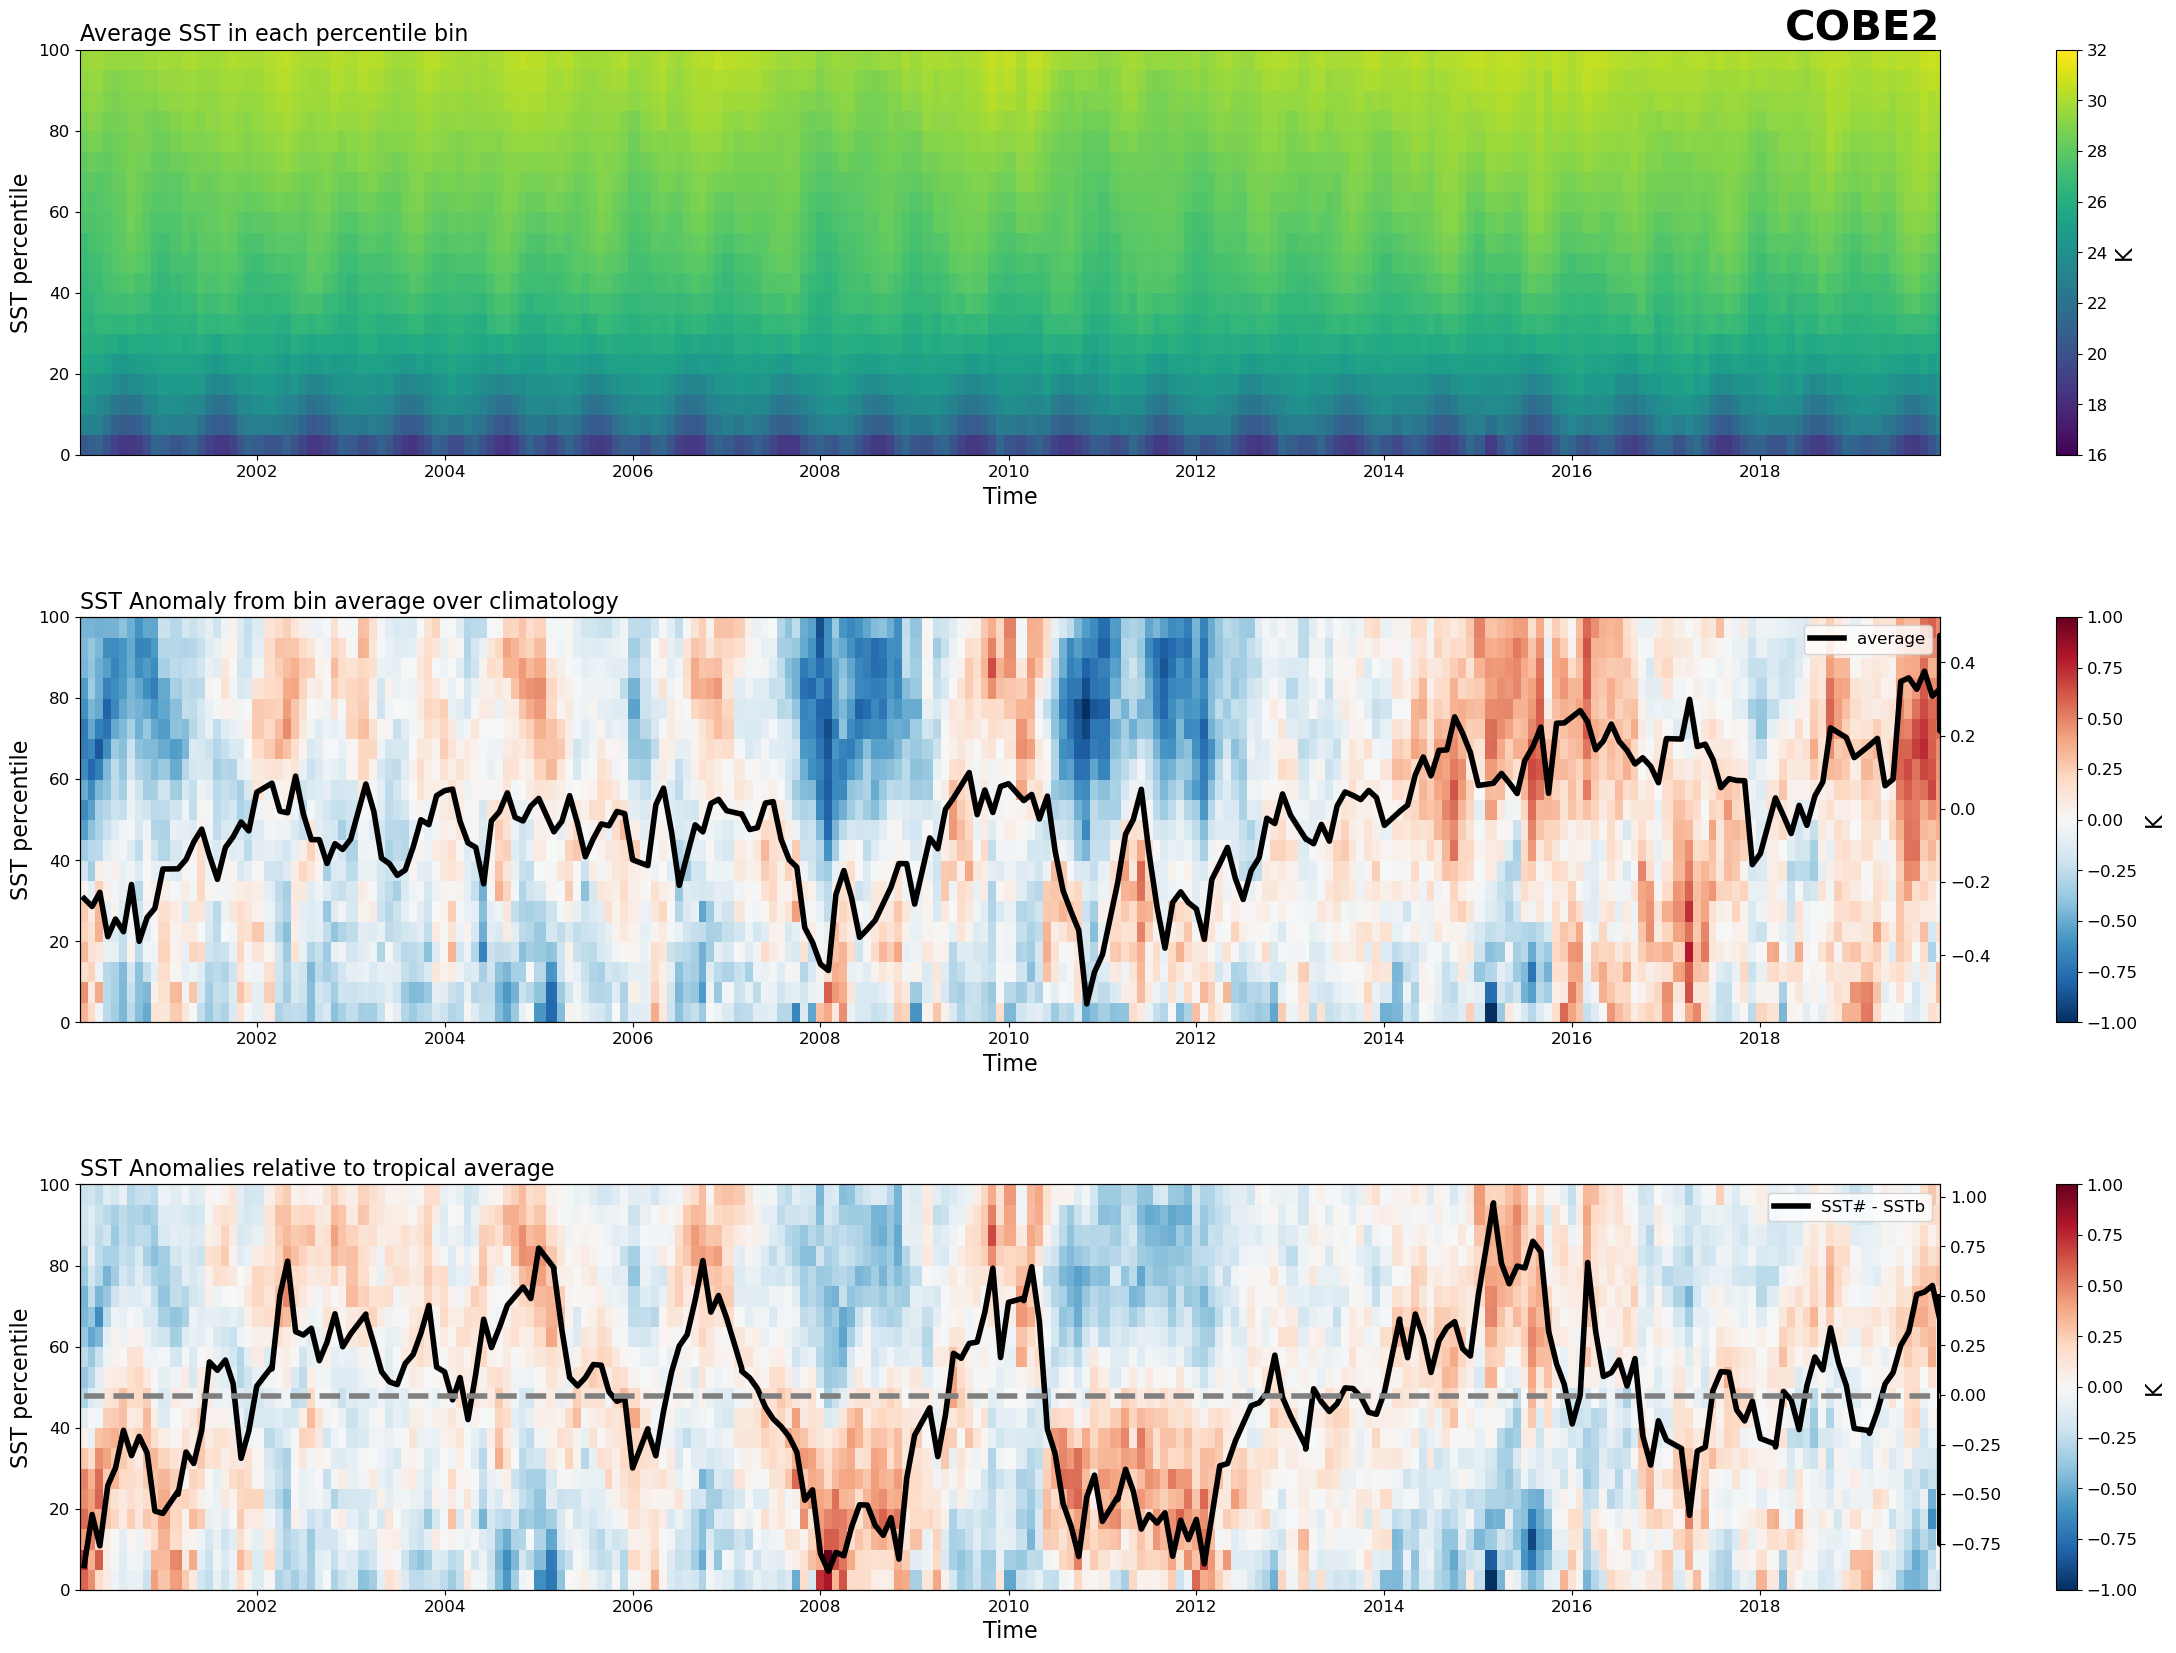

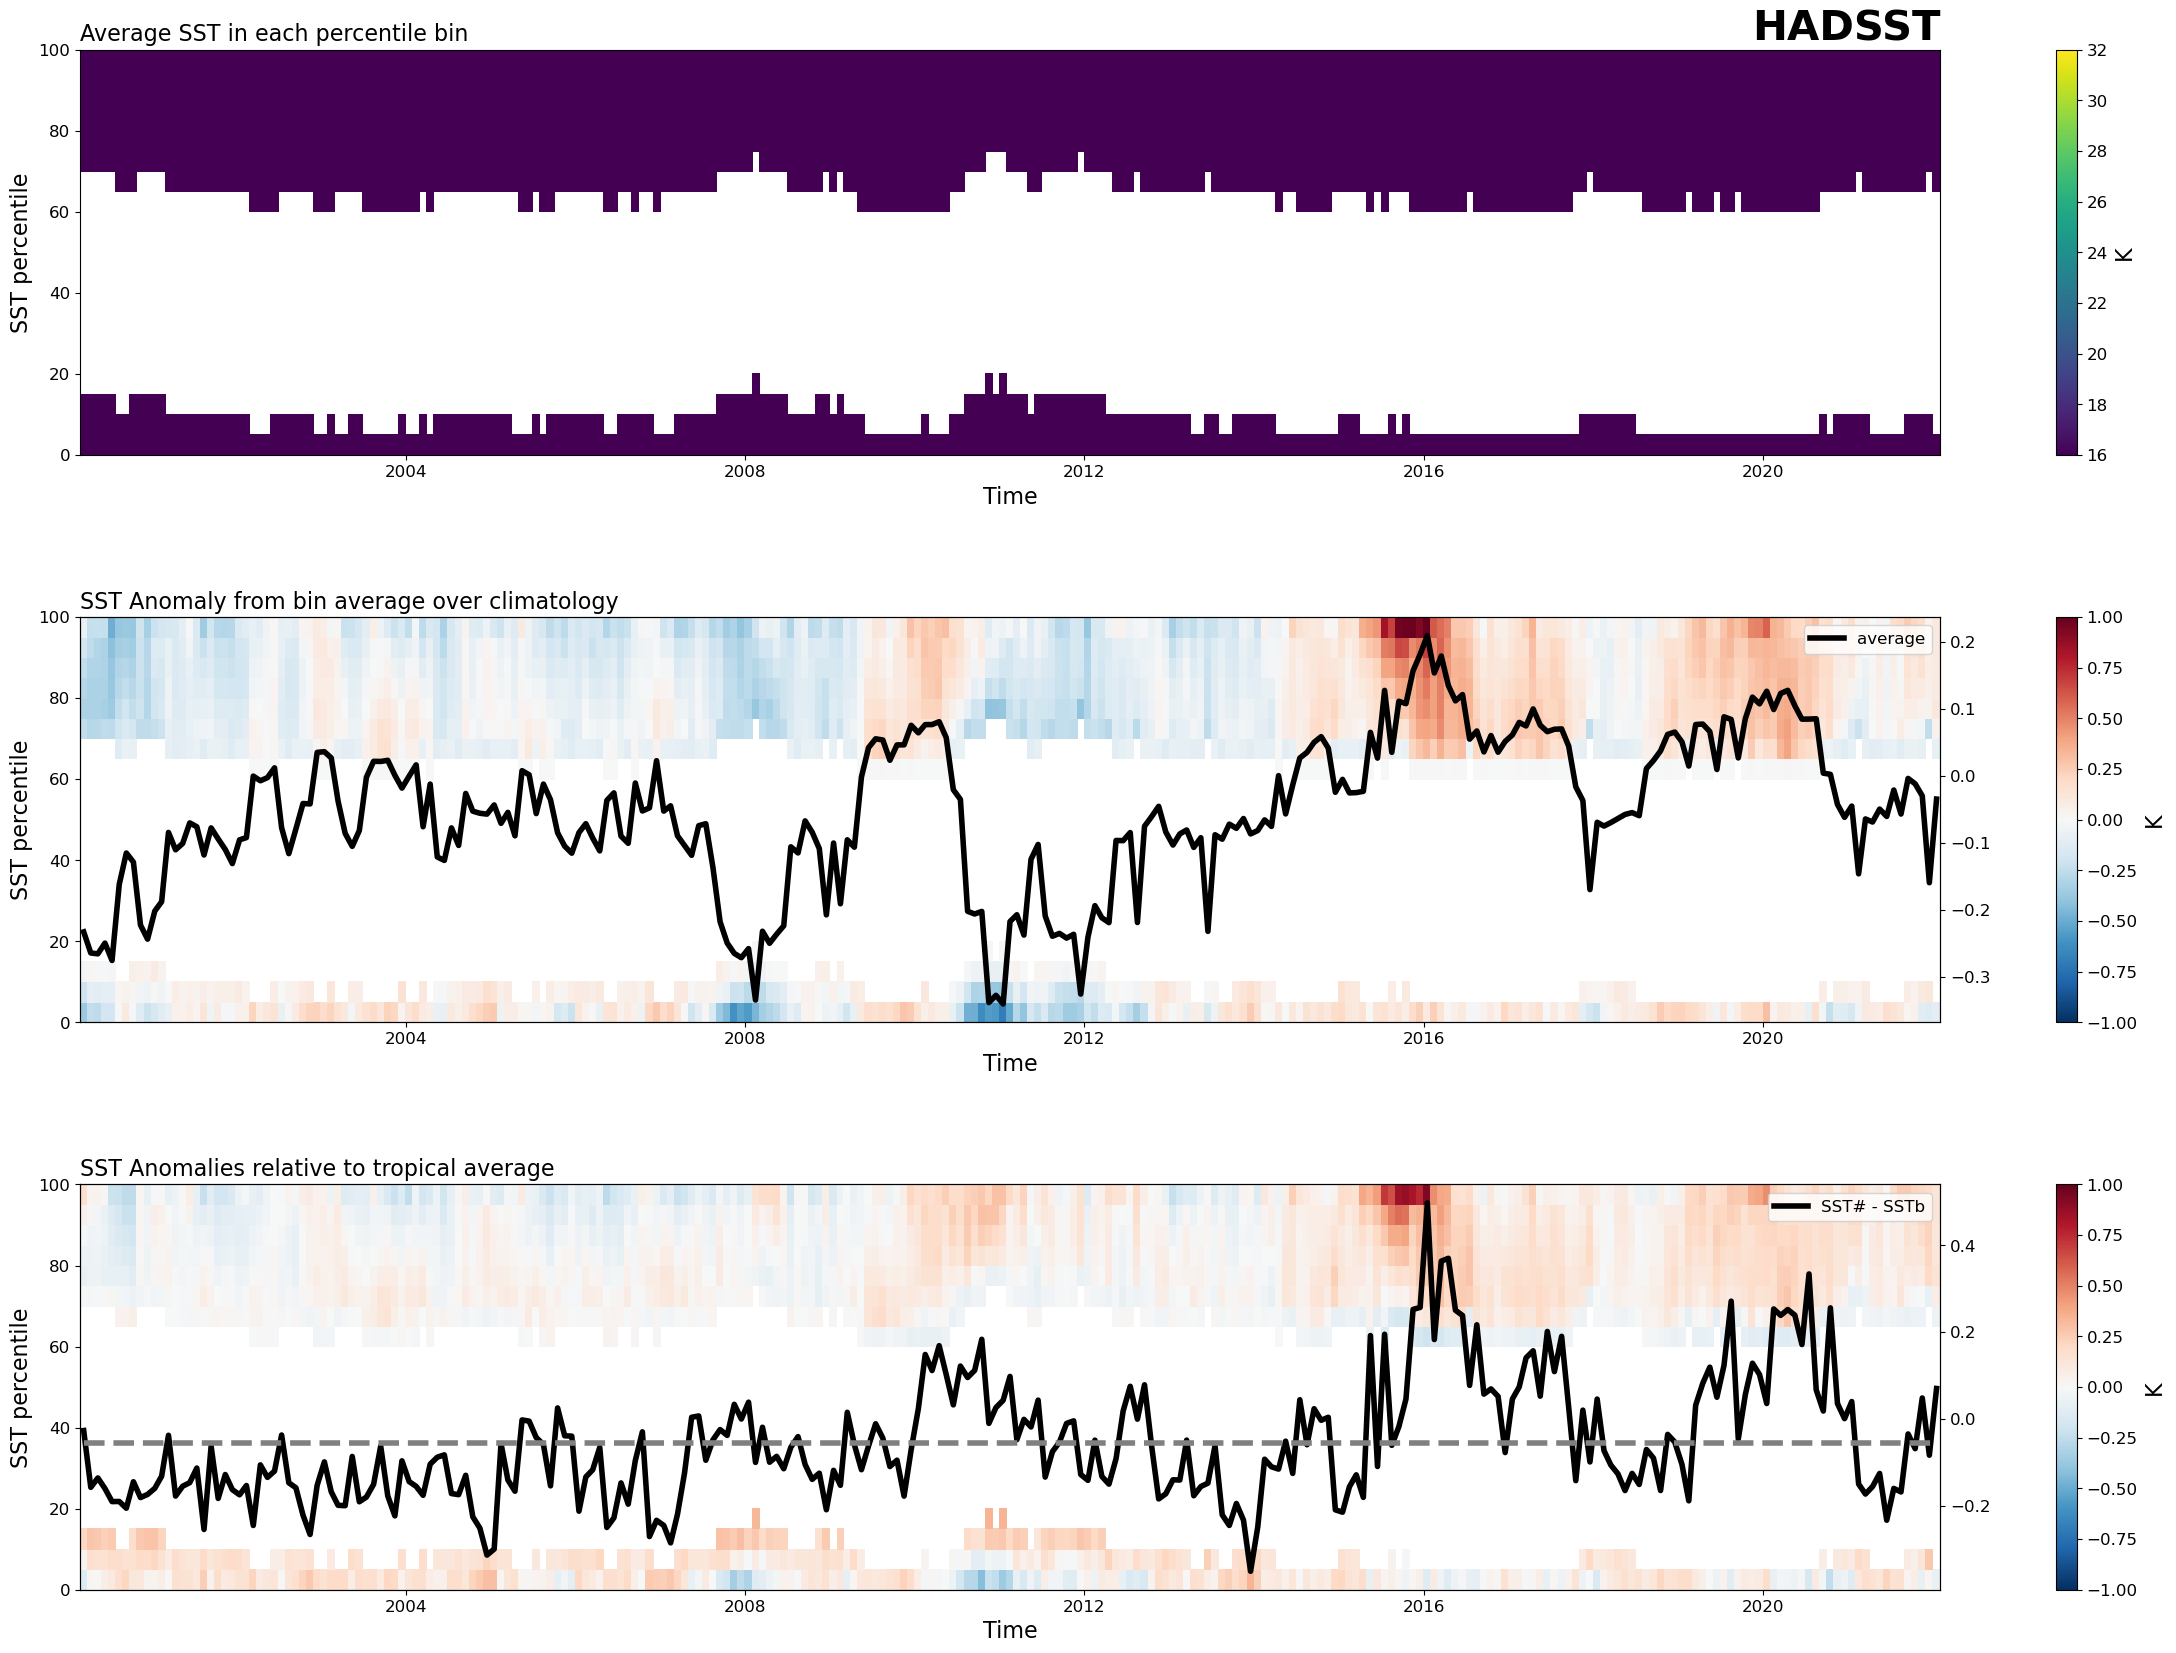

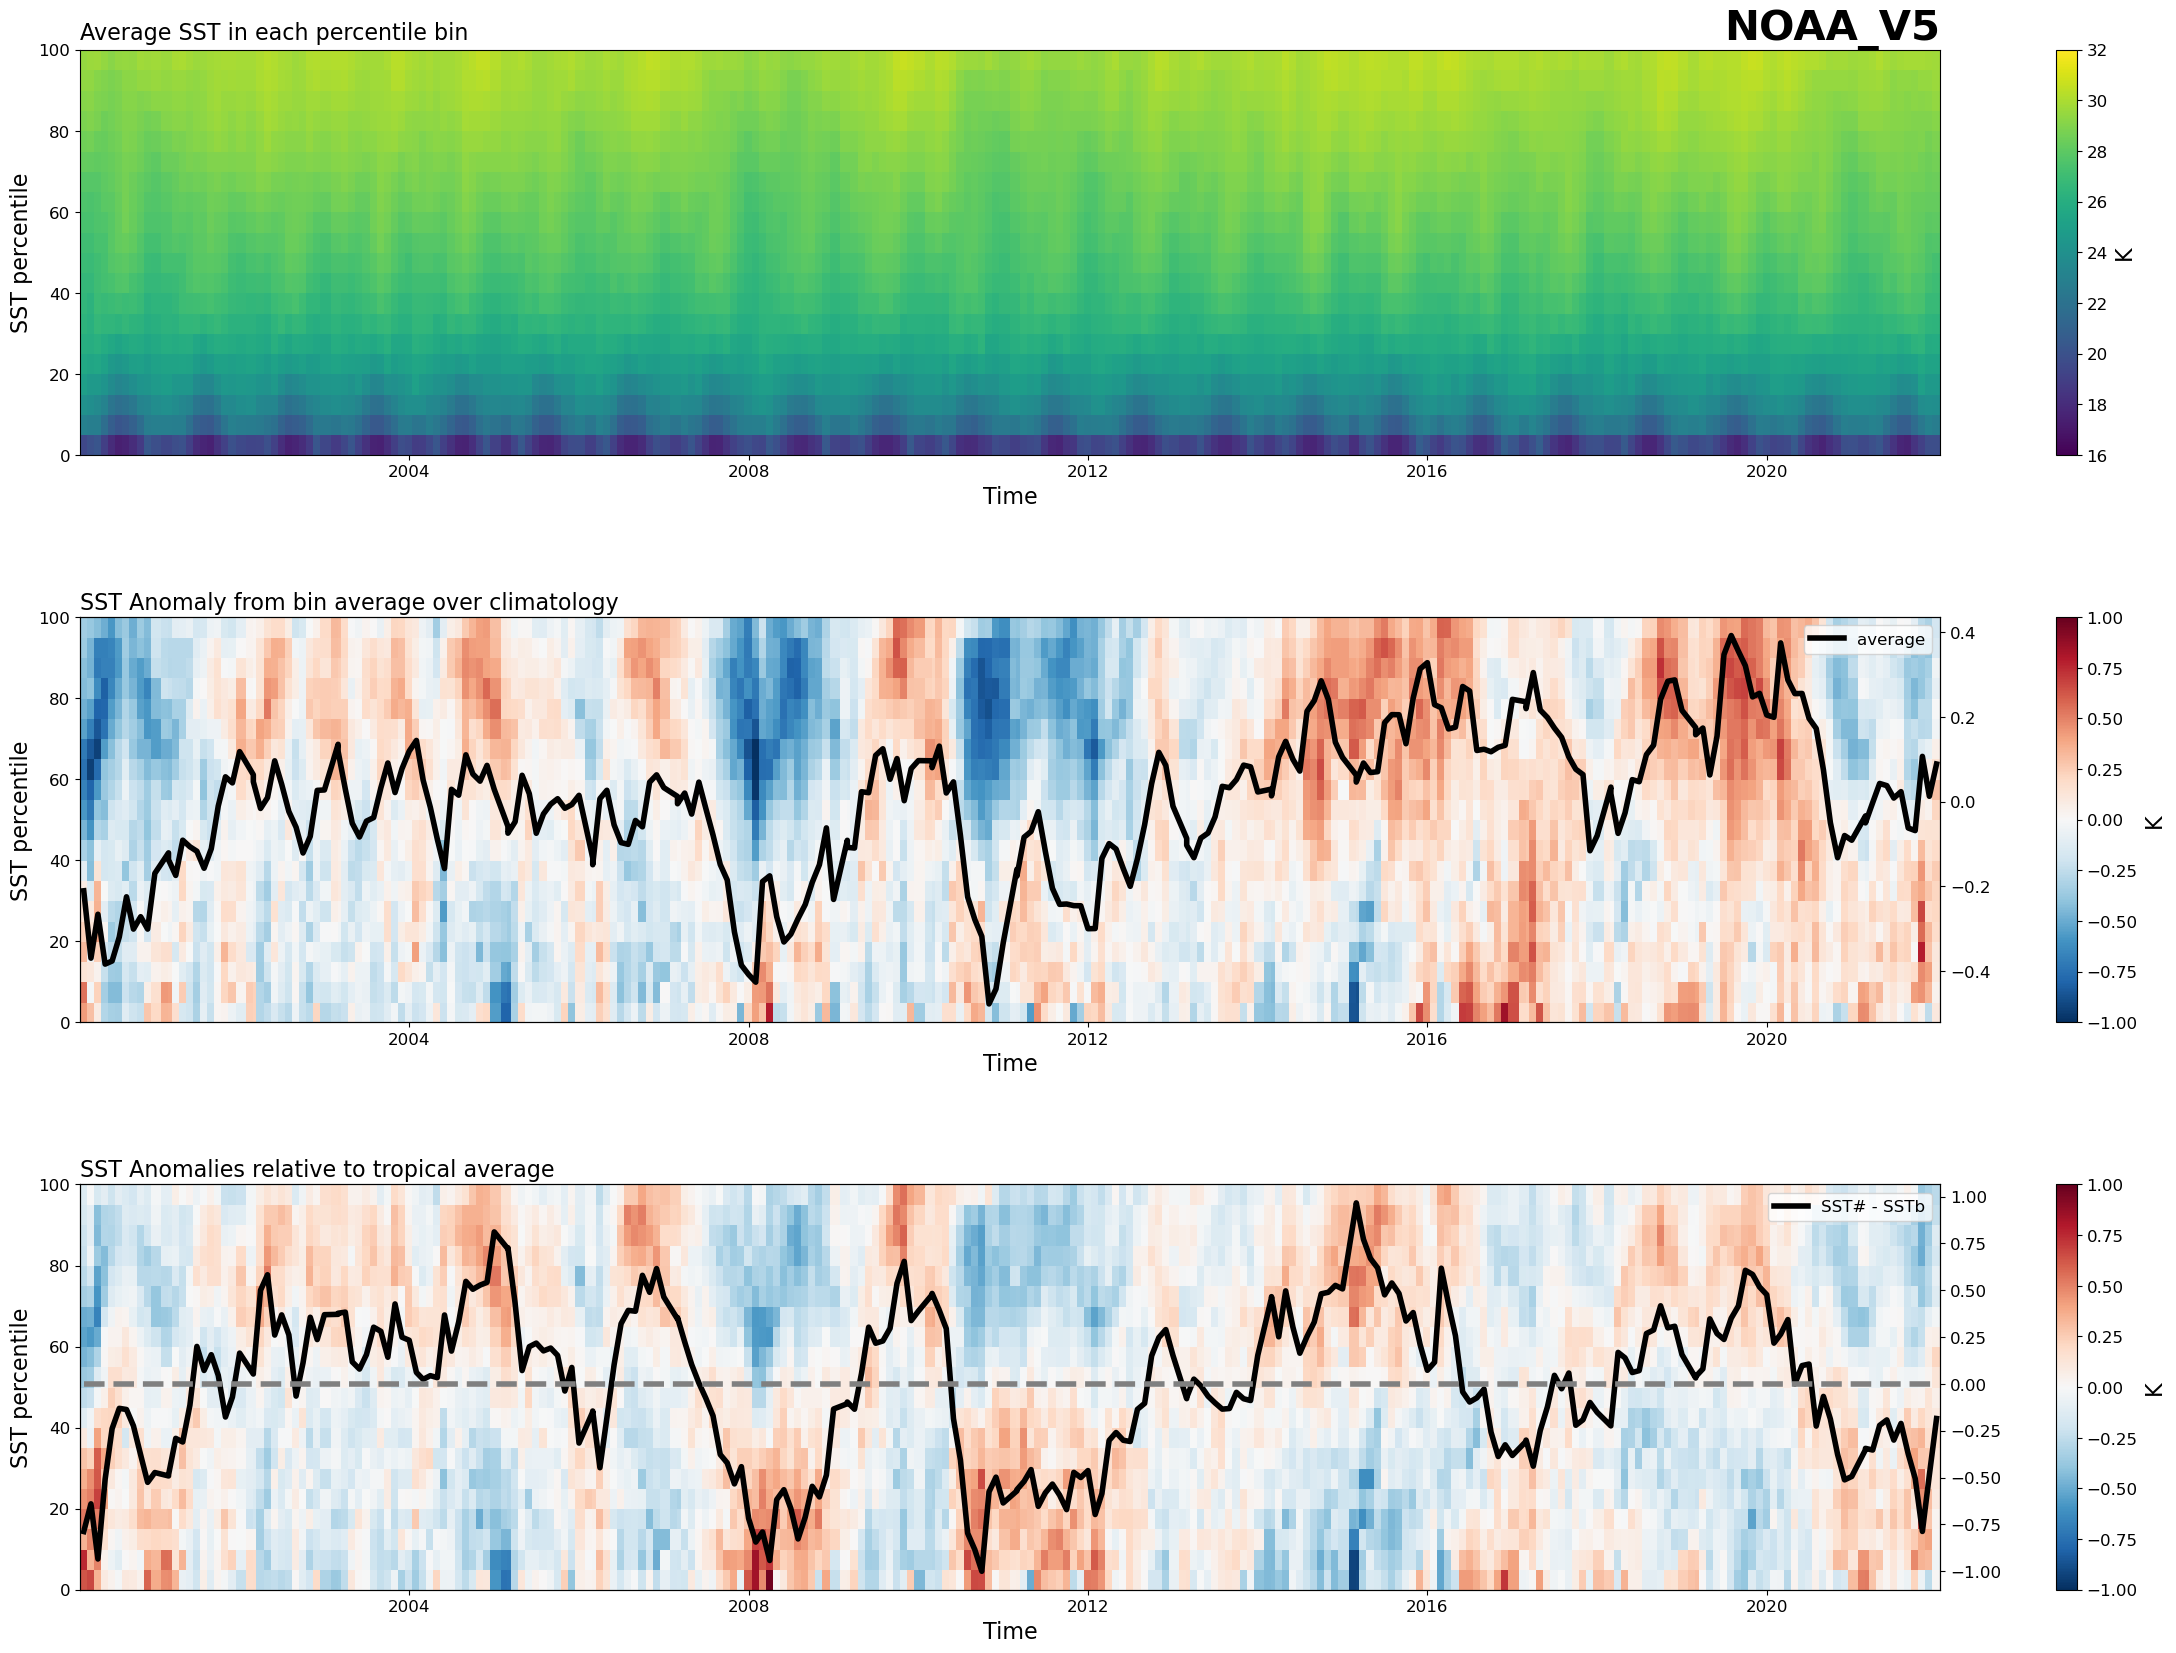

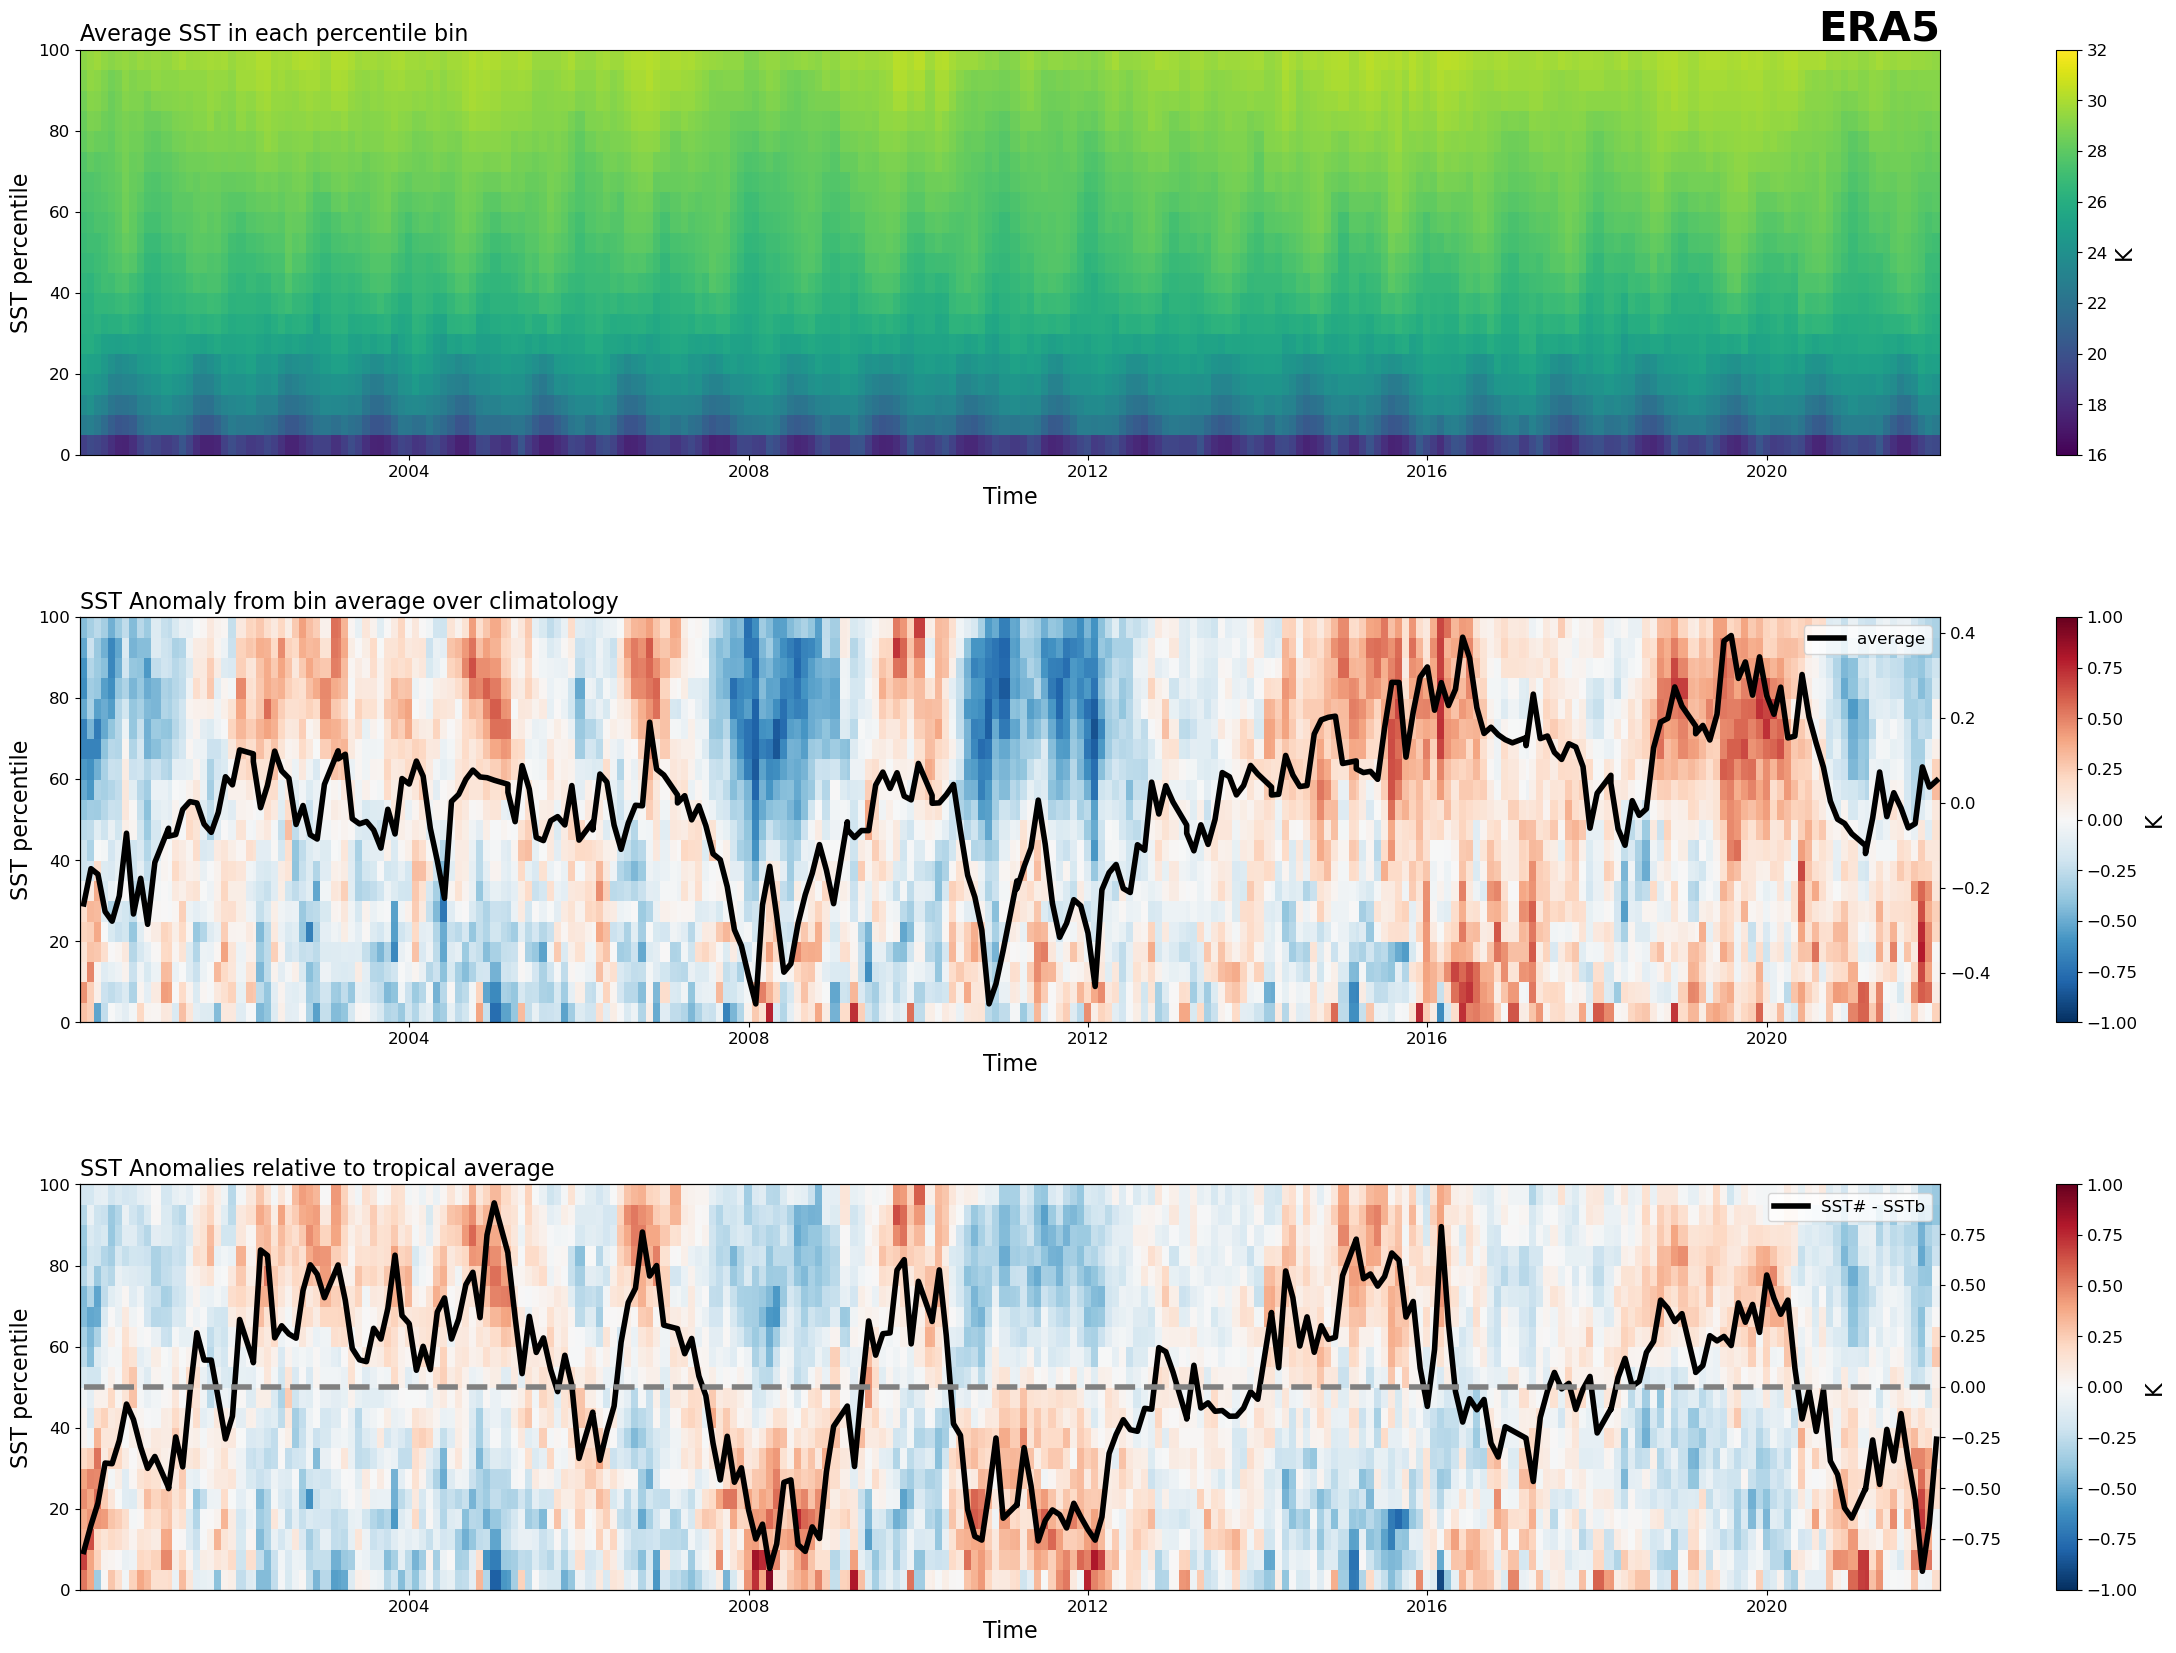

In [78]:
cobe2_sharp = calculate_SSTsharp(tos=cobe2_tropics, weights=weights_tropics, era="obs", ds_name="COBE2")
hadsst4_sharp = calculate_SSTsharp(tos=hadsst4_tropics, weights=weights_tropics, era="obs", ds_name="HADSST")
noaaV5_sharp = calculate_SSTsharp(tos=noaaV5_tropics, weights=weights_tropics, era="obs", ds_name="NOAA_V5")
era5sst_sharp = calculate_SSTsharp(tos=era5sst_tropics, weights=weights_tropics, era="obs", ds_name="ERA5")

## Process SWCRE Obs

<xarray.DataArray 'binanom' (bins: 20)>
array([  2.04942109,  -1.64882042,   4.08685591,   3.14512583,
         3.55704951,  -2.2840306 ,  12.70886816,  -1.49545075,
        -7.02132113,  -4.81493666, -11.26671824,  -8.9916166 ,
        -6.42504406, -13.10247107, -11.68319178,  -5.67218481,
       -10.25039937,  -6.28138692,  -7.66462292, -18.50598557])
Coordinates:
  * bins     (bins) float64 2.5 7.5 12.5 17.5 22.5 ... 77.5 82.5 87.5 92.5 97.5
<xarray.DataArray 'binanom' (bins: 20)>
array([  1.37276788,  -1.02636282,   0.1835267 ,   3.38539953,
         4.04616998,   1.46357923,   5.84523982,   6.11656013,
        -5.56852902,  -9.348139  ,  -9.16748094, -11.2218801 ,
        -8.25138457, -16.21114039, -16.27595734, -16.44416687,
        -8.42331379,   0.51614754,   2.94932746,   6.40234393])
Coordinates:
  * bins     (bins) float64 2.5 7.5 12.5 17.5 22.5 ... 77.5 82.5 87.5 92.5 97.5
<xarray.DataArray 'binanom' (bins: 20)>
array([  3.46617552,   0.39338643,   3.53144081,   4.31263174,

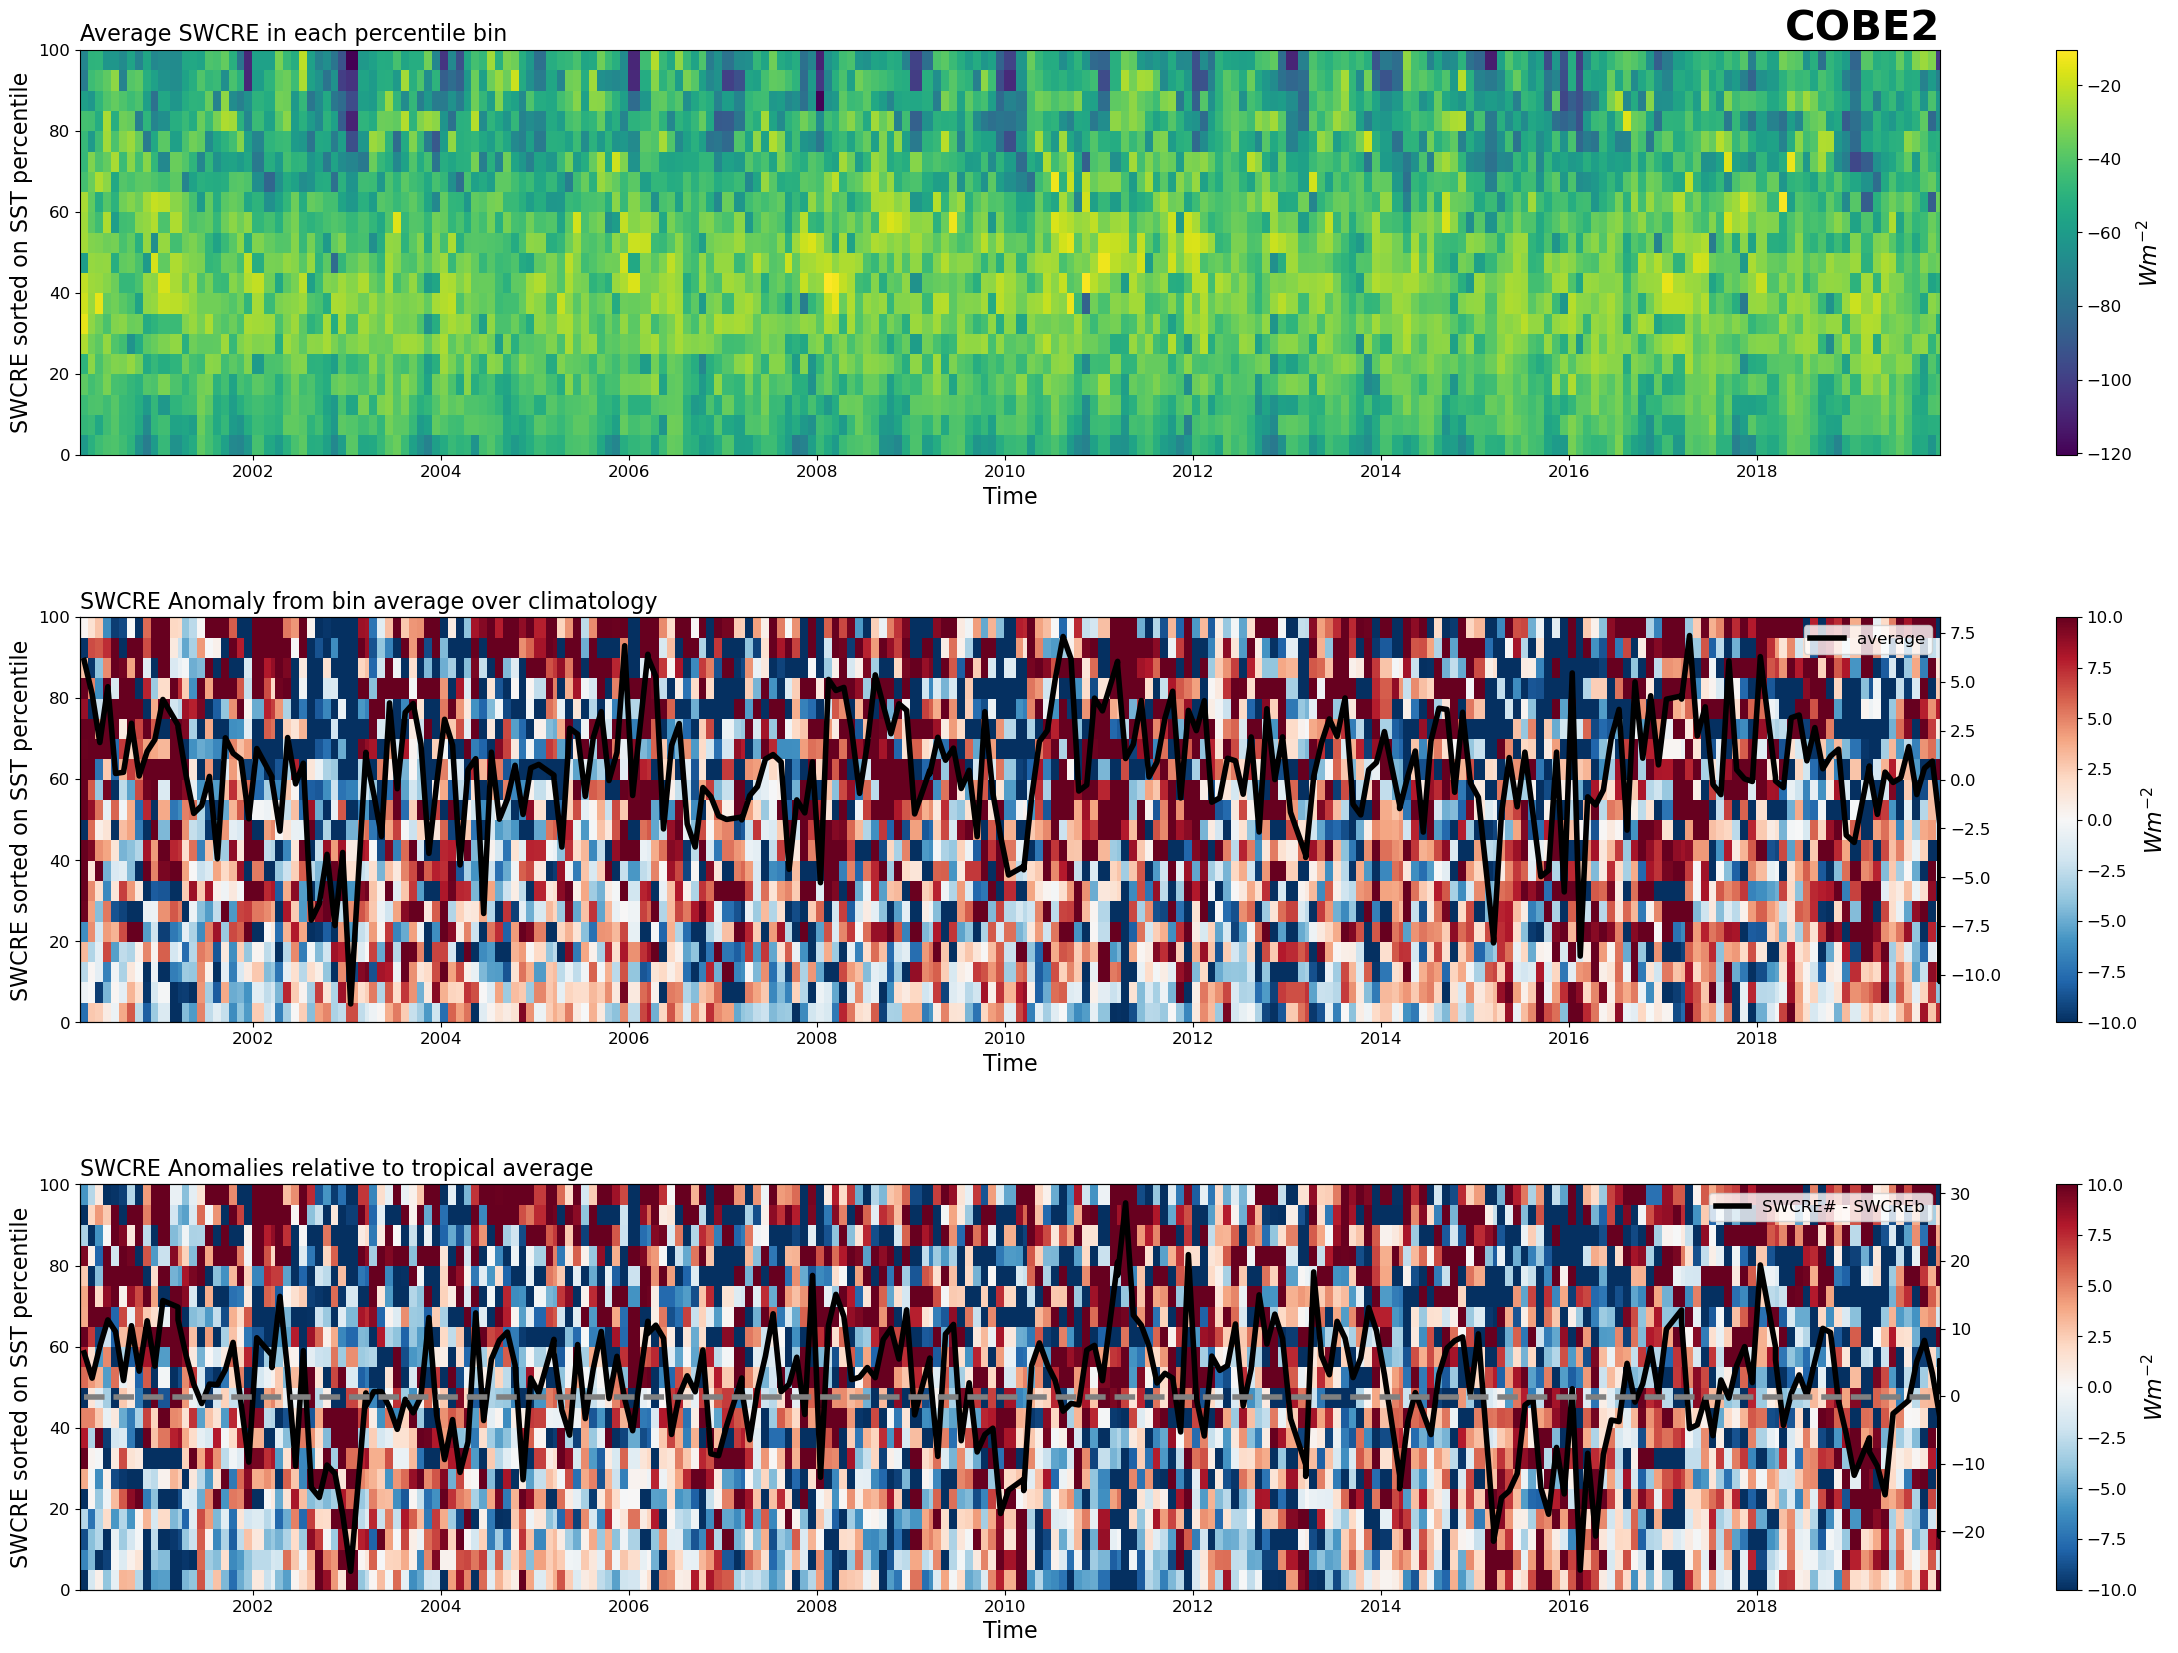

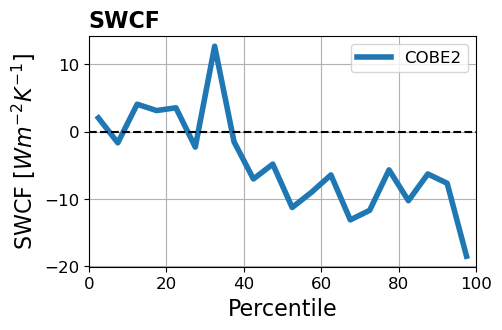

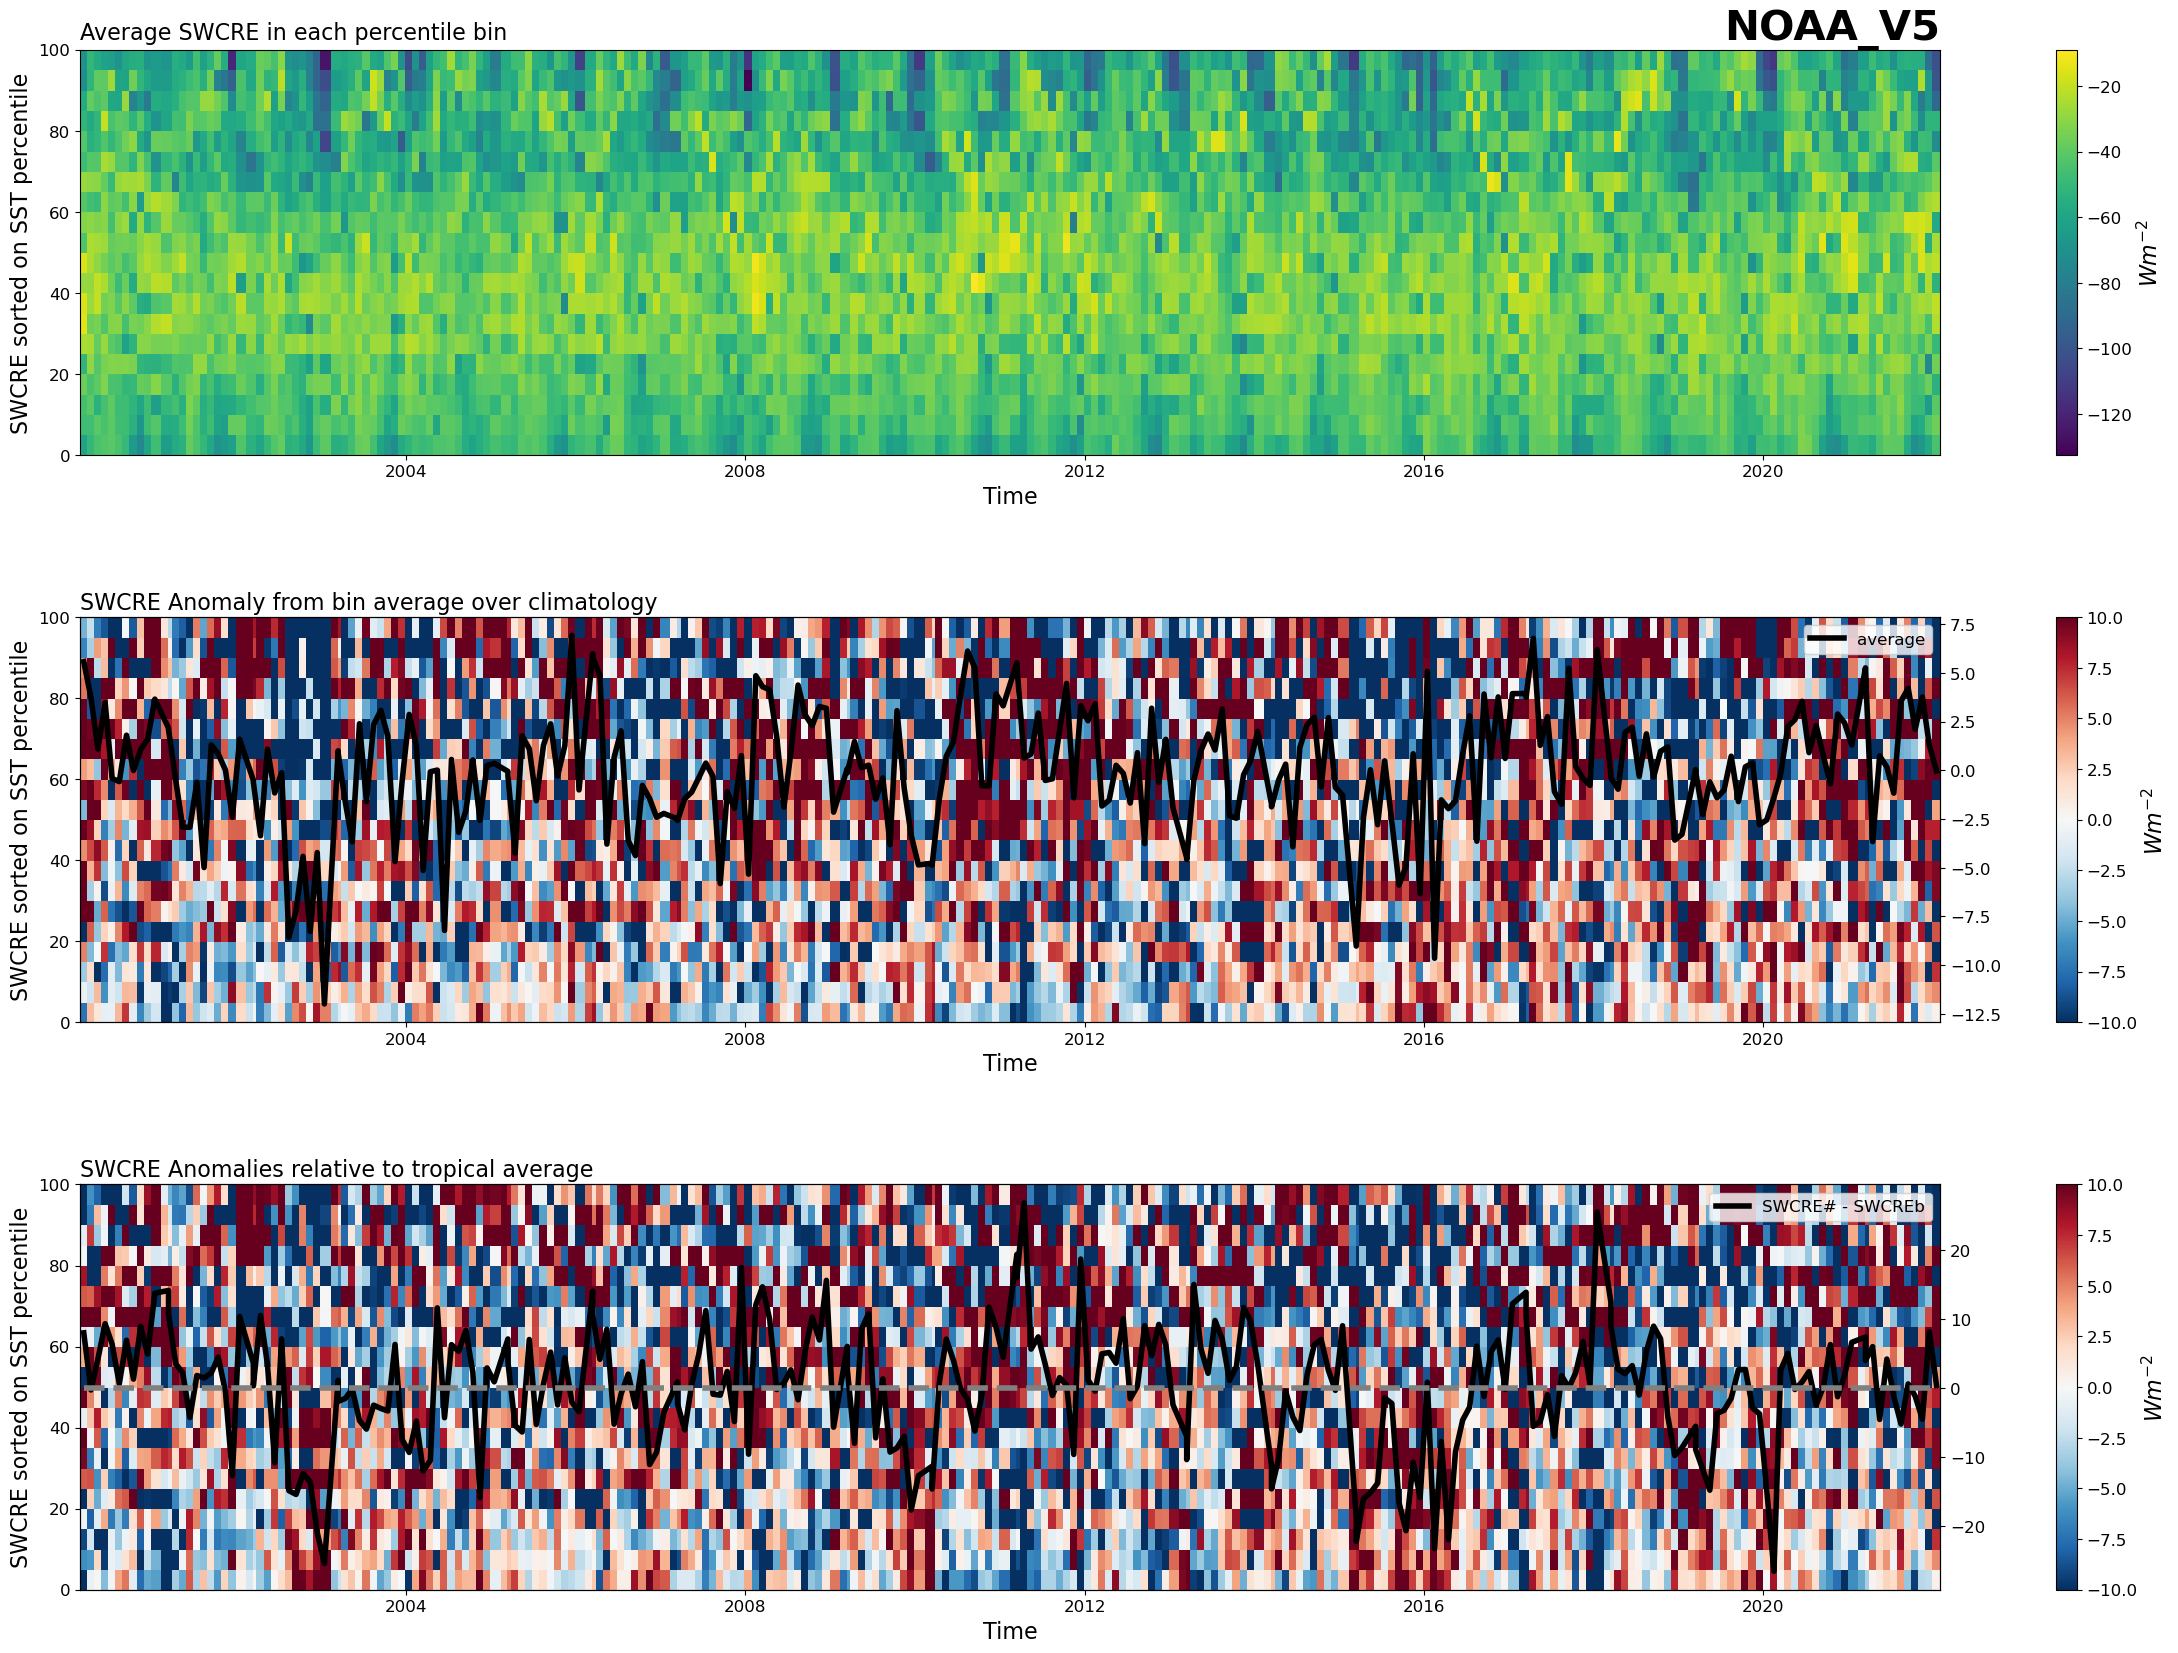

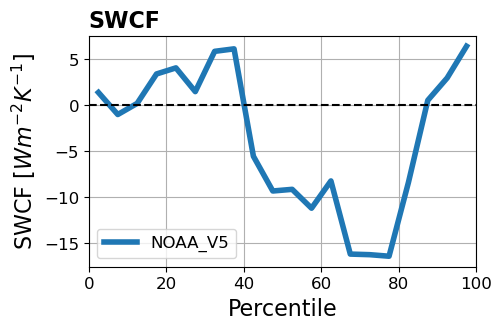

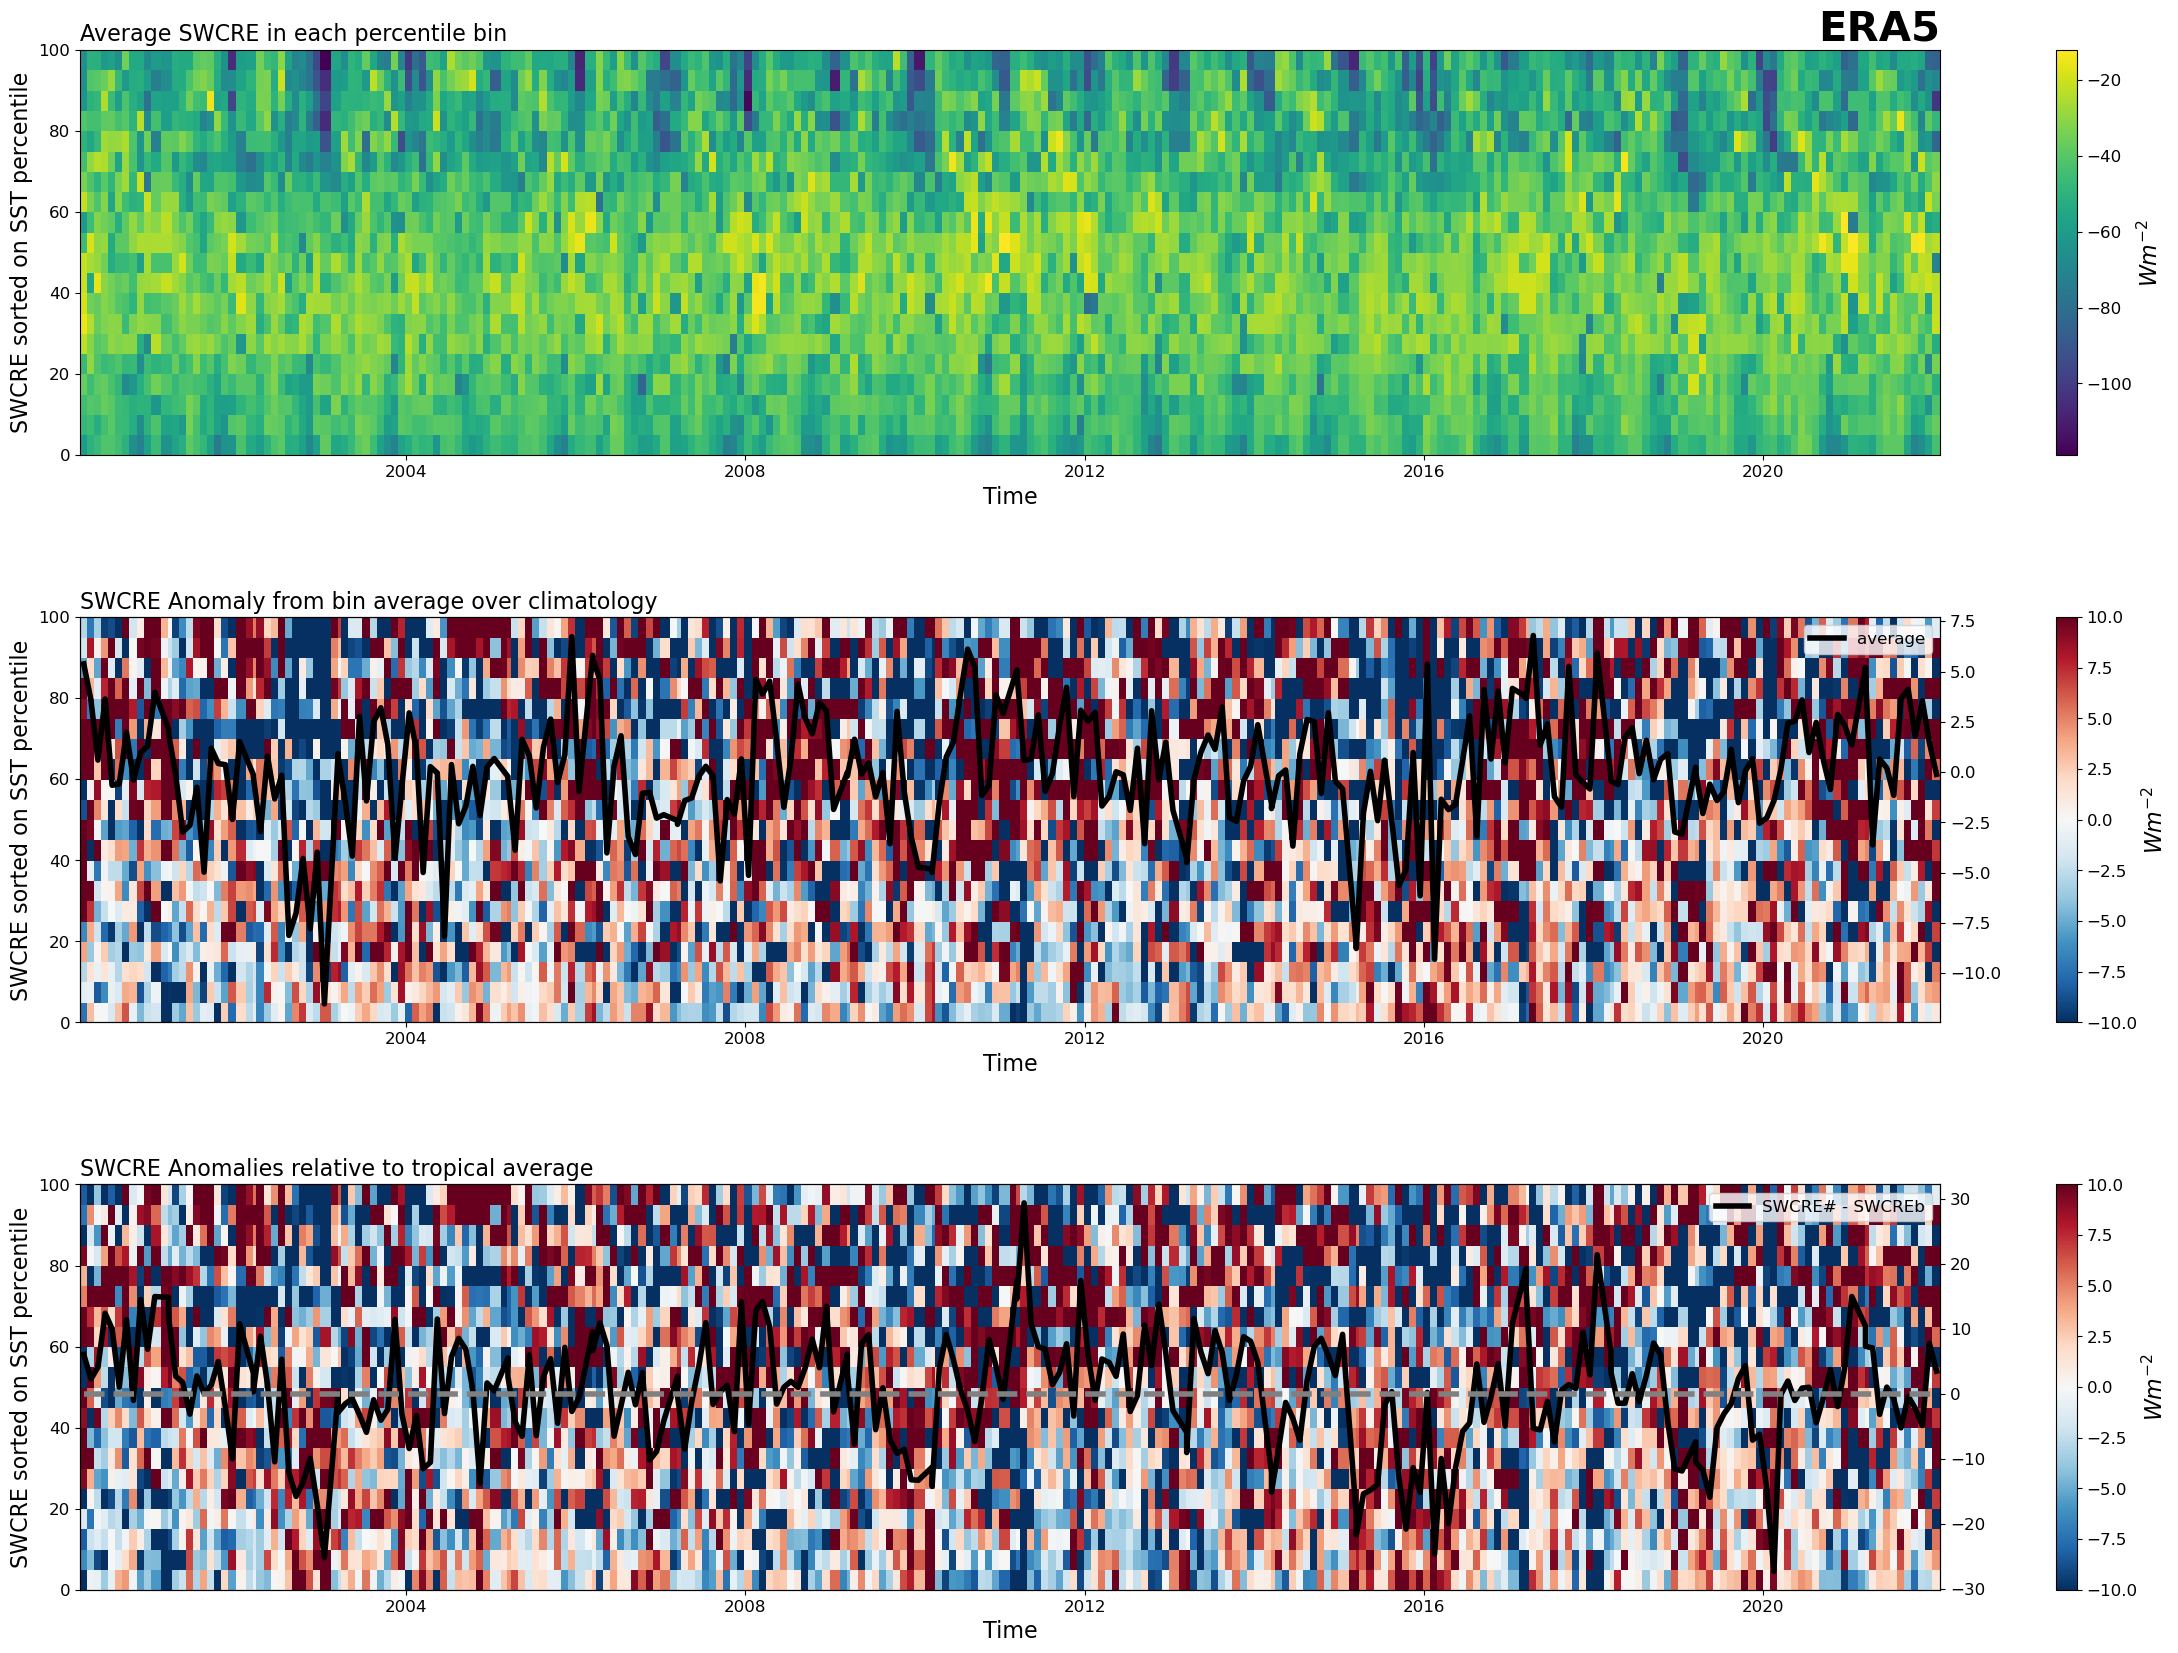

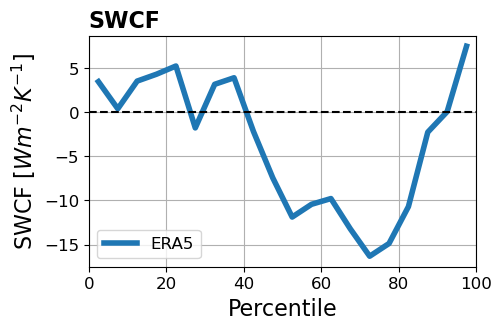

In [94]:
def calculate_SWCREsharp(
    swcre: xr.DataArray, 
    weights: xr.DataArray, 
    era: str = "", 
    sst_obs: str = ""
) -> xr.Dataset:
    """_summary_

    Args:
        save (bool, optional): _description_. Defaults to False.
        testing (bool, optional): _description_. Defaults to False.

    Returns:
        xr.Dataset: _description_
    """

    # Load SSTsharp package
    ds_sharp = xr.open_dataset(f"data/sharp/{era}/SSTsharp_{sst_obs}.nc")
    
    swcre = swcre.sel(time=ds_sharp.time, method="nearest")
    
    # Calculate SWCREsharp Package
    swcre_sharp = apply_SSTsharp_to_SWCRE(
        da=swcre,
        ds_sharp=ds_sharp, 
        prctl_bins=prctl_bins,
        weights=weights,
        model=sst_obs
    )
    # Create SWCRE figures
    create_swcre_percentile_figures(swcre_sharp, model=sst_obs)
    # Reindex Time to align with SSTs

    swcre_sharp["time"] = ds_sharp.time

    # Save SWCREsharp Package
    swcre_sharp.to_netcdf(f"data/sharp/{era}/SWCREsharp_{sst_obs}.nc")
    # Calculate SWCF
    swcf_sharp = calculate_swcf_percentiles(SSTsharp=ds_sharp, SWCREsharp=swcre_sharp)
    # Calculate SWCF
    plot_swcf(swcf=swcf_sharp, model=sst_obs)
    # Save SWCF package
    swcf_sharp.to_netcdf(f"data/sharp/{era}/SWCF_{sst_obs}.nc")
    # Close SSTsharp package
    ds_sharp.close()
        
    return swcre_sharp

swcre_cobe2 = calculate_SWCREsharp(swcre=swcre_tropics, weights=weights_tropics, sst_obs="COBE2", era="obs")
swcre_noaa = calculate_SWCREsharp(swcre=swcre_tropics, weights=weights_tropics, sst_obs="NOAA_V5", era="obs")
swcre_era5 = calculate_SWCREsharp(swcre=swcre_tropics, weights=weights_tropics, sst_obs="ERA5", era="obs")